In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import datetime, warnings, scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from datetime import datetime as dt
from sklearn.metrics import mean_squared_error



plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('/content/drive/MyDrive/ML_project/Train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/ML_project/Test.csv')
df_sample= pd.read_csv('/content/drive/MyDrive/ML_project/SampleSubmission.csv')

In [5]:
df.head()

ID       DATOP     FLTID DEPSTN ARRSTN                  STD  \
0  train_id_0  2016-01-03  TU 0712     CMN    TUN  2016-01-03 10:30:00   
1  train_id_1  2016-01-13  TU 0757     MXP    TUN  2016-01-13 15:05:00   
2  train_id_2  2016-01-16  TU 0214     TUN    IST  2016-01-16 04:10:00   
3  train_id_3  2016-01-17  TU 0480     DJE    NTE  2016-01-17 14:10:00   
4  train_id_4  2016-01-17  TU 0338     TUN    ALG  2016-01-17 14:30:00   

                   STA STATUS         AC  target  
0  2016-01-03 12.55.00    ATA  TU 32AIMN   260.0  
1  2016-01-13 16.55.00    ATA  TU 31BIMO    20.0  
2  2016-01-16 06.45.00    ATA  TU 32AIMN     0.0  
3  2016-01-17 17.00.00    ATA  TU 736IOK     0.0  
4  2016-01-17 15.50.00    ATA  TU 320IMU    22.0

In [6]:
df['DATOP'].unique()

array(['2016-01-03', '2016-01-13', '2016-01-16', ..., '2018-12-28',
       '2018-12-29', '2018-12-30'], dtype=object)

**Dates of flights from 2016-01-03 till 2018-12-30**

DATOP - Date of flight

FLTID - Flight number

DEPSTN - Departure point

ARRSTN - Arrival point

STD - Scheduled Time departure

STA - Scheduled Time arrival

STATUS - Flight status

AC - Aircraft Code

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      107833 non-null  object 
 1   DATOP   107833 non-null  object 
 2   FLTID   107833 non-null  object 
 3   DEPSTN  107833 non-null  object 
 4   ARRSTN  107833 non-null  object 
 5   STD     107833 non-null  object 
 6   STA     107833 non-null  object 
 7   STATUS  107833 non-null  object 
 8   AC      107833 non-null  object 
 9   target  107833 non-null  float64
dtypes: float64(1), object(9)
memory usage: 8.2+ MB


In [8]:
df.shape

(107833, 10)

In [9]:
df['target'].mean()

48.73301308504818

In [10]:
# # df[['DATOP', 'STD', 'STA']]
df['STD'] =  pd.to_datetime(df['STD'], format='%Y-%m-%d %H:%M:%S')
df['STA'] =  pd.to_datetime(df['STA'], format='%Y-%m-%d %H.%M.%S')
df['DATOP'] =  pd.to_datetime(df['DATOP'], format='%Y-%m-%d')

df_test['STD'] =  pd.to_datetime(df_test['STD'], format='%Y-%m-%d %H:%M:%S')
df_test['STA'] =  pd.to_datetime(df_test['STA'], format='%Y-%m-%d %H.%M.%S')
df_test['DATOP'] =  pd.to_datetime(df_test['DATOP'], format='%Y-%m-%d')

In [11]:
# there is a space after the flight id
df['FLTID'] = df['FLTID'].astype(str).str[:-1]
df_test['FLTID'] = df_test['FLTID'].astype(str).str[:-1]

In [12]:
df['FLTID'][0]

'TU 0712'

In [13]:
df['STATUS'].unique()

array(['ATA', 'DEP', 'RTR', 'SCH', 'DEL'], dtype=object)

In [14]:
df.isnull().sum(axis=0).reset_index()

index  0
0      ID  0
1   DATOP  0
2   FLTID  0
3  DEPSTN  0
4  ARRSTN  0
5     STD  0
6     STA  0
7  STATUS  0
8      AC  0
9  target  0

We don't have missing values

In [15]:
df['AC'].unique()

array(['TU 32AIMN', 'TU 31BIMO', 'TU 736IOK', 'TU 320IMU', 'TU 736IOP',
       'TU 32AIMH', 'TU 32AIMI', 'TU 32AIMC', 'TU 31AIMK', 'TU 32AIMF',
       'TU 32AIMP', 'TU 320IMR', 'TU 332IFN', 'TU 31AIMJ', 'TU 320IMT',
       'TU 736IOL', 'TU 31BIMQ', 'TU 736IOR', 'TU 320IMV', 'TU 320IMS',
       'TU 332IFM', 'TU 320IMW', 'TU 32AIML', 'TU 32AIMD', 'TU 32AIMM',
       'TU CR9ISA', 'TU 32AIMG', 'TU 736ION', 'TU 736IOM', 'TU 736IOQ',
       '5M 343SUN', 'UG AT7LBD', '5K 343TQY', 'UG AT7LBE', 'UG AT7AT7',
       'BJ 320INP', 'BJ 320INH', 'BJ 320INQ', 'BJ 320INA', 'UG CR9XXX',
       'UG CR9CR9', 'TU 32A32A', 'BJ 320INB', 'GJ 734CGC', 'QS 738TSC',
       'PS 738PSD', 'D4 319CQG', 'BJ 320INR', 'BJ 320INC', 'UJ 320TCF',
       '5K 345TFX', 'D4 320CQP', '5M 343JAI', 'GW 320MQH', 'UG CR9ISA',
       '6P M87TRJ', 'TU CR9CR9', 'TU CR9XXX', 'GJ 733EWE', 'GJ 734PGC',
       'GJ 733GGC', 'GJ 734MGC', 'GJ 733LGC', '5M 343FOX', 'BJ 320INO',
       'OL 321ABY', 'X9 320VEB', 'TU 320320'], dtype=object)

In [16]:
df['target'].mean()

48.73301308504818

**The mean delay time is 48.73 minutes let's take a closer look on how the delay times are dispersed**


<h2> Comparing delay times per AC </h2>

In [17]:
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['target'].groupby(df['AC']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

min     max   count        mean
AC                                        
TU 320320  0.0     0.0     1.0    0.000000
TU CR9XXX  0.0     0.0     2.0    0.000000
TU 32A32A  0.0     0.0     2.0    0.000000
OL 321ABY  0.0   302.0     5.0  205.400000
TU CR9CR9  0.0     0.0     6.0    0.000000
...        ...     ...     ...         ...
TU 320IMV  0.0  2042.0  4589.0   56.915232
TU 320IMR  0.0  1890.0  4601.0   58.260378
TU 320IMT  0.0  2835.0  4634.0   58.406129
TU 320IMW  0.0  2745.0  4685.0   61.432444
TU 320IMU  0.0  3317.0  4724.0   58.867697

[68 rows x 4 columns]

In [18]:
global_stats.sort_values('max')

min     max   count       mean
AC                                       
TU 320320  0.0     0.0     1.0   0.000000
TU CR9XXX  0.0     0.0     2.0   0.000000
TU 32A32A  0.0     0.0     2.0   0.000000
UG CR9CR9  0.0     0.0    30.0   0.000000
UG AT7AT7  0.0     0.0  1441.0   0.000000
...        ...     ...     ...        ...
TU 320IMS  0.0  2942.0  4214.0  57.329616
TU 736IOQ  0.0  2980.0  3072.0  39.202474
TU 32AIML  0.0  3245.0  4122.0  61.064774
TU 320IMU  0.0  3317.0  4724.0  58.867697
TU 32AIMM  0.0  3451.0  2632.0  63.453267

[68 rows x 4 columns]

**The mean delay times are between 0 minutes and 205.4 minutes (the max delay of all flights is 3451 minutes)**

(-1.099999999930318,
 1.0999999999966819,
 -1.099999999841133,
 1.0999999999924328)

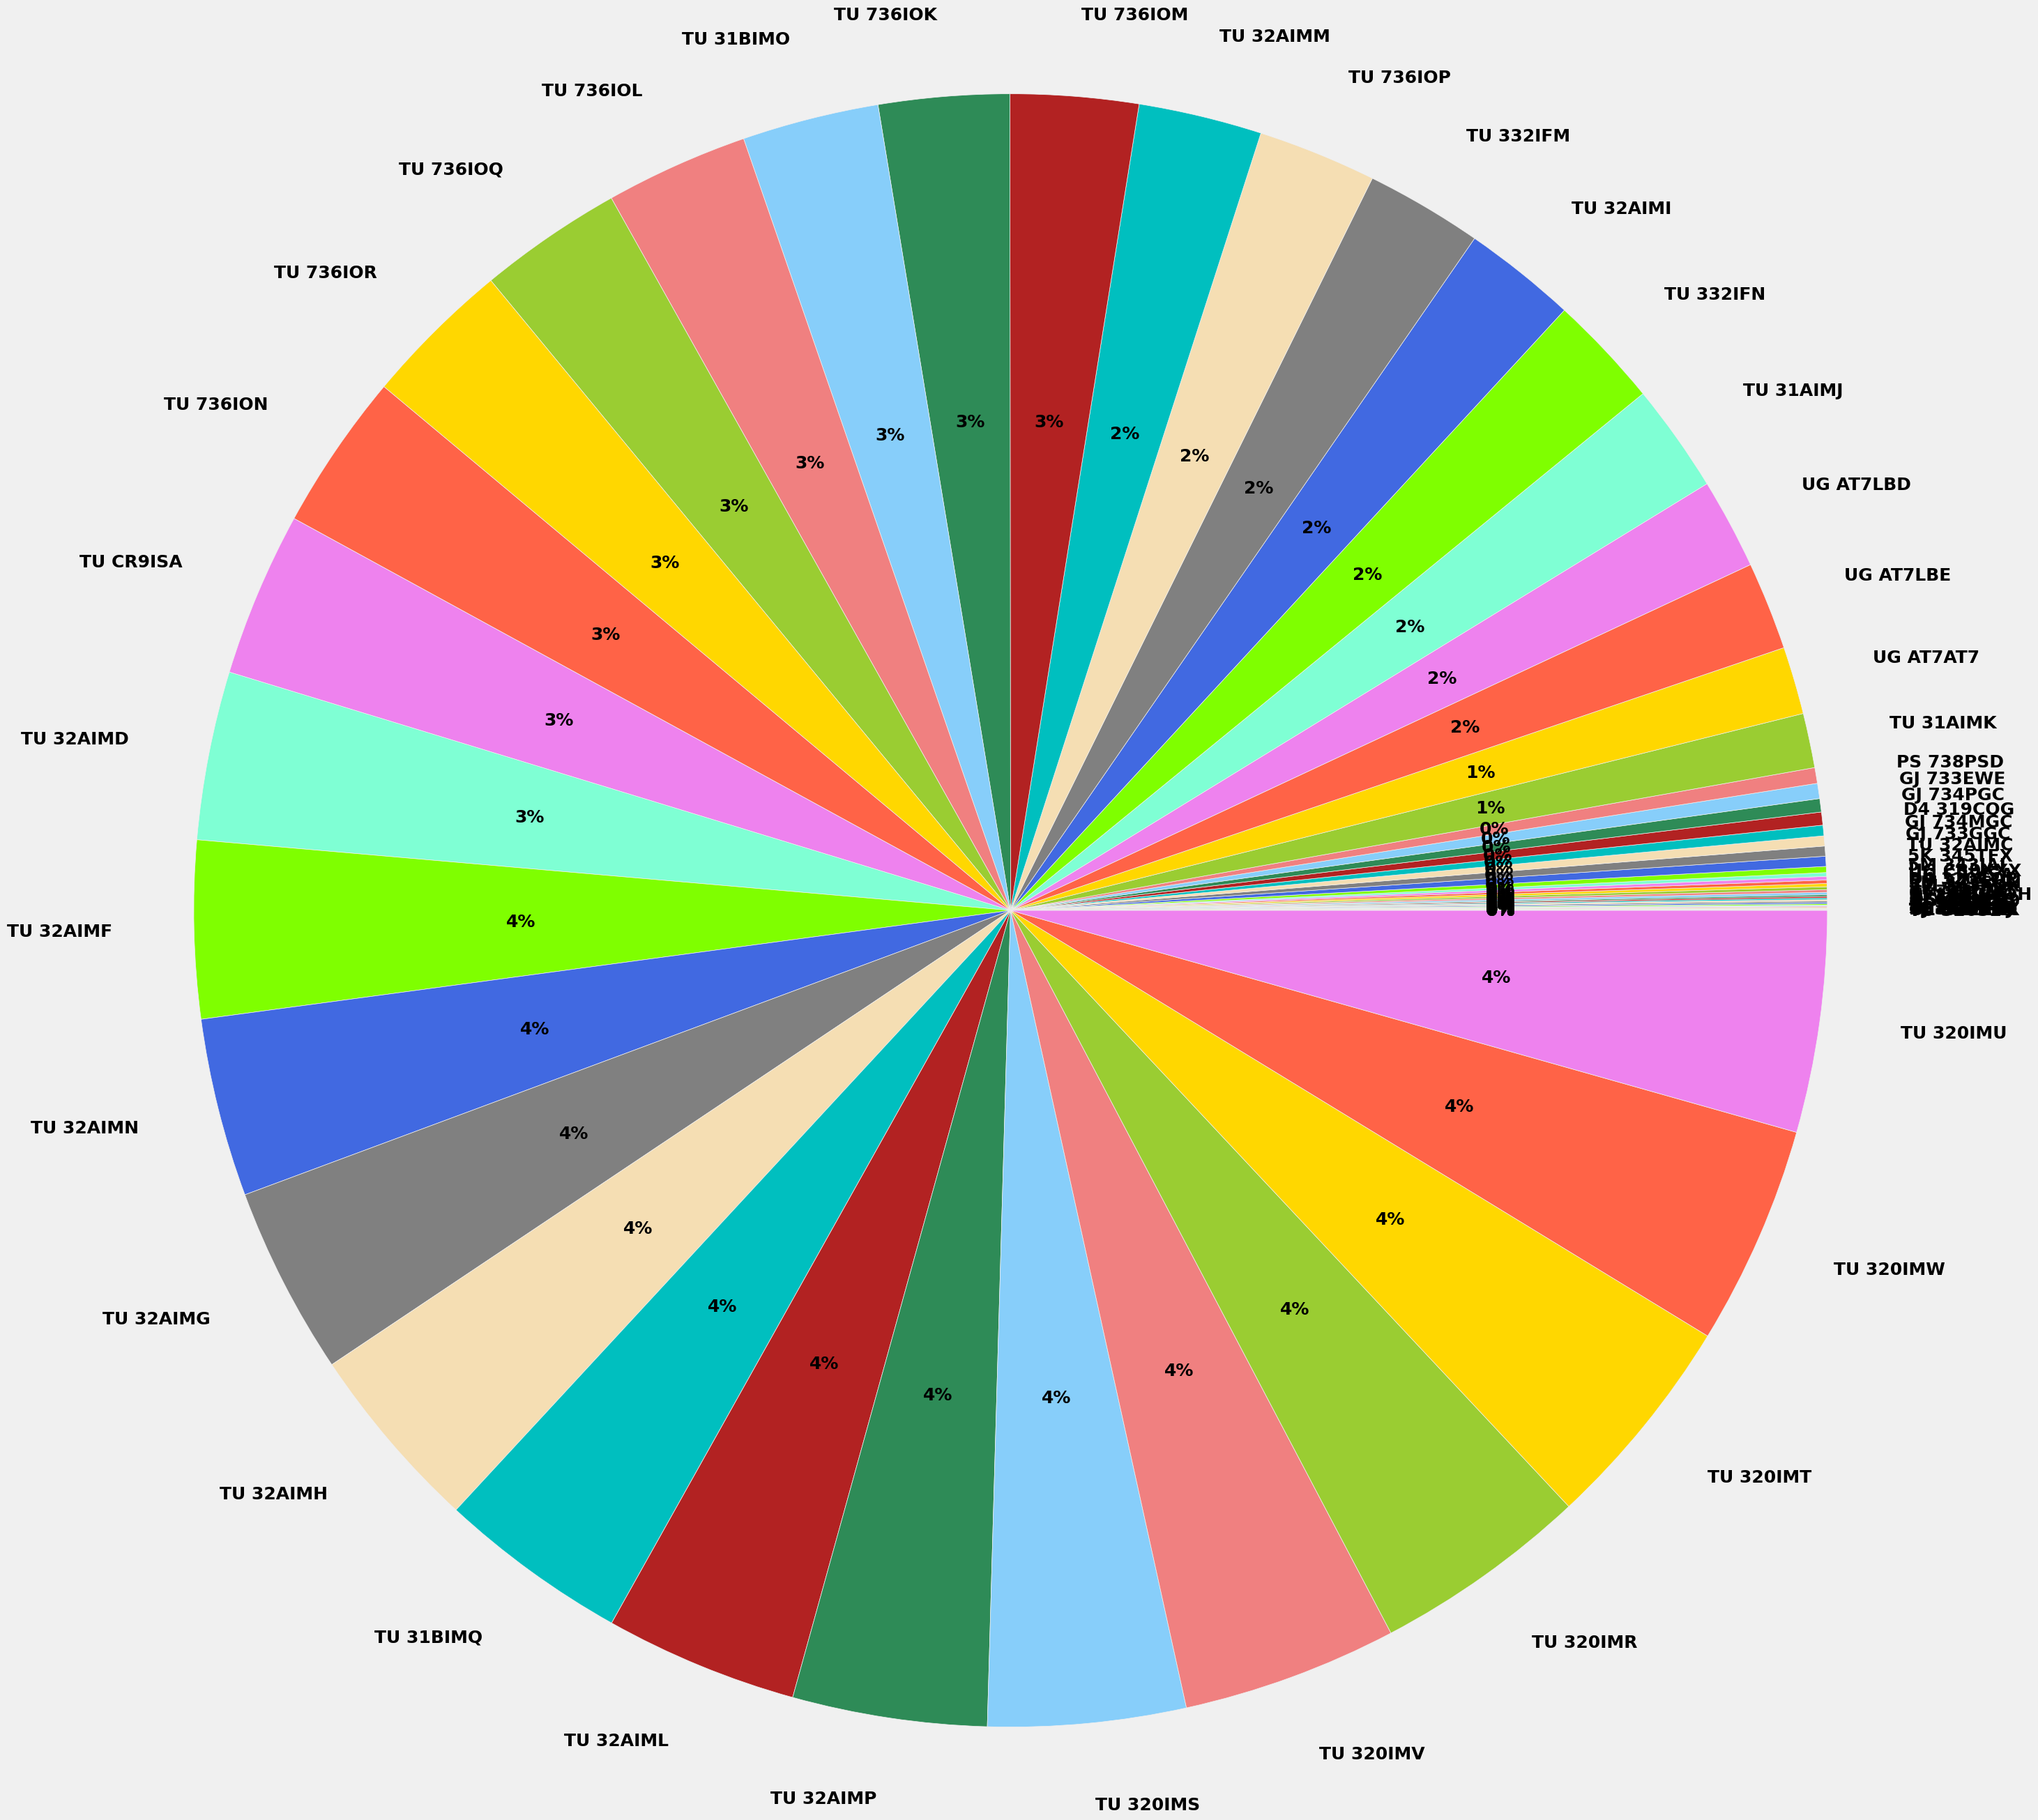

In [19]:
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 18}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
#__________________________________________________________________
df2 = df.loc[:, ['AC', 'target']]
#________________________________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']

fig = plt.figure(1, figsize=(70,70))
gs=GridSpec(2,2)
ax1=fig.add_subplot(gs[0,0])
# Pie chart nº1: nb of flights
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 1.0 else 0.0 for i in range(len(sizes))]
patches, texts, autotexts = ax1.pie(sizes, explode=explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
ax1.axis('equal')
# ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':10},
#               color = 'w',fontsize=18)

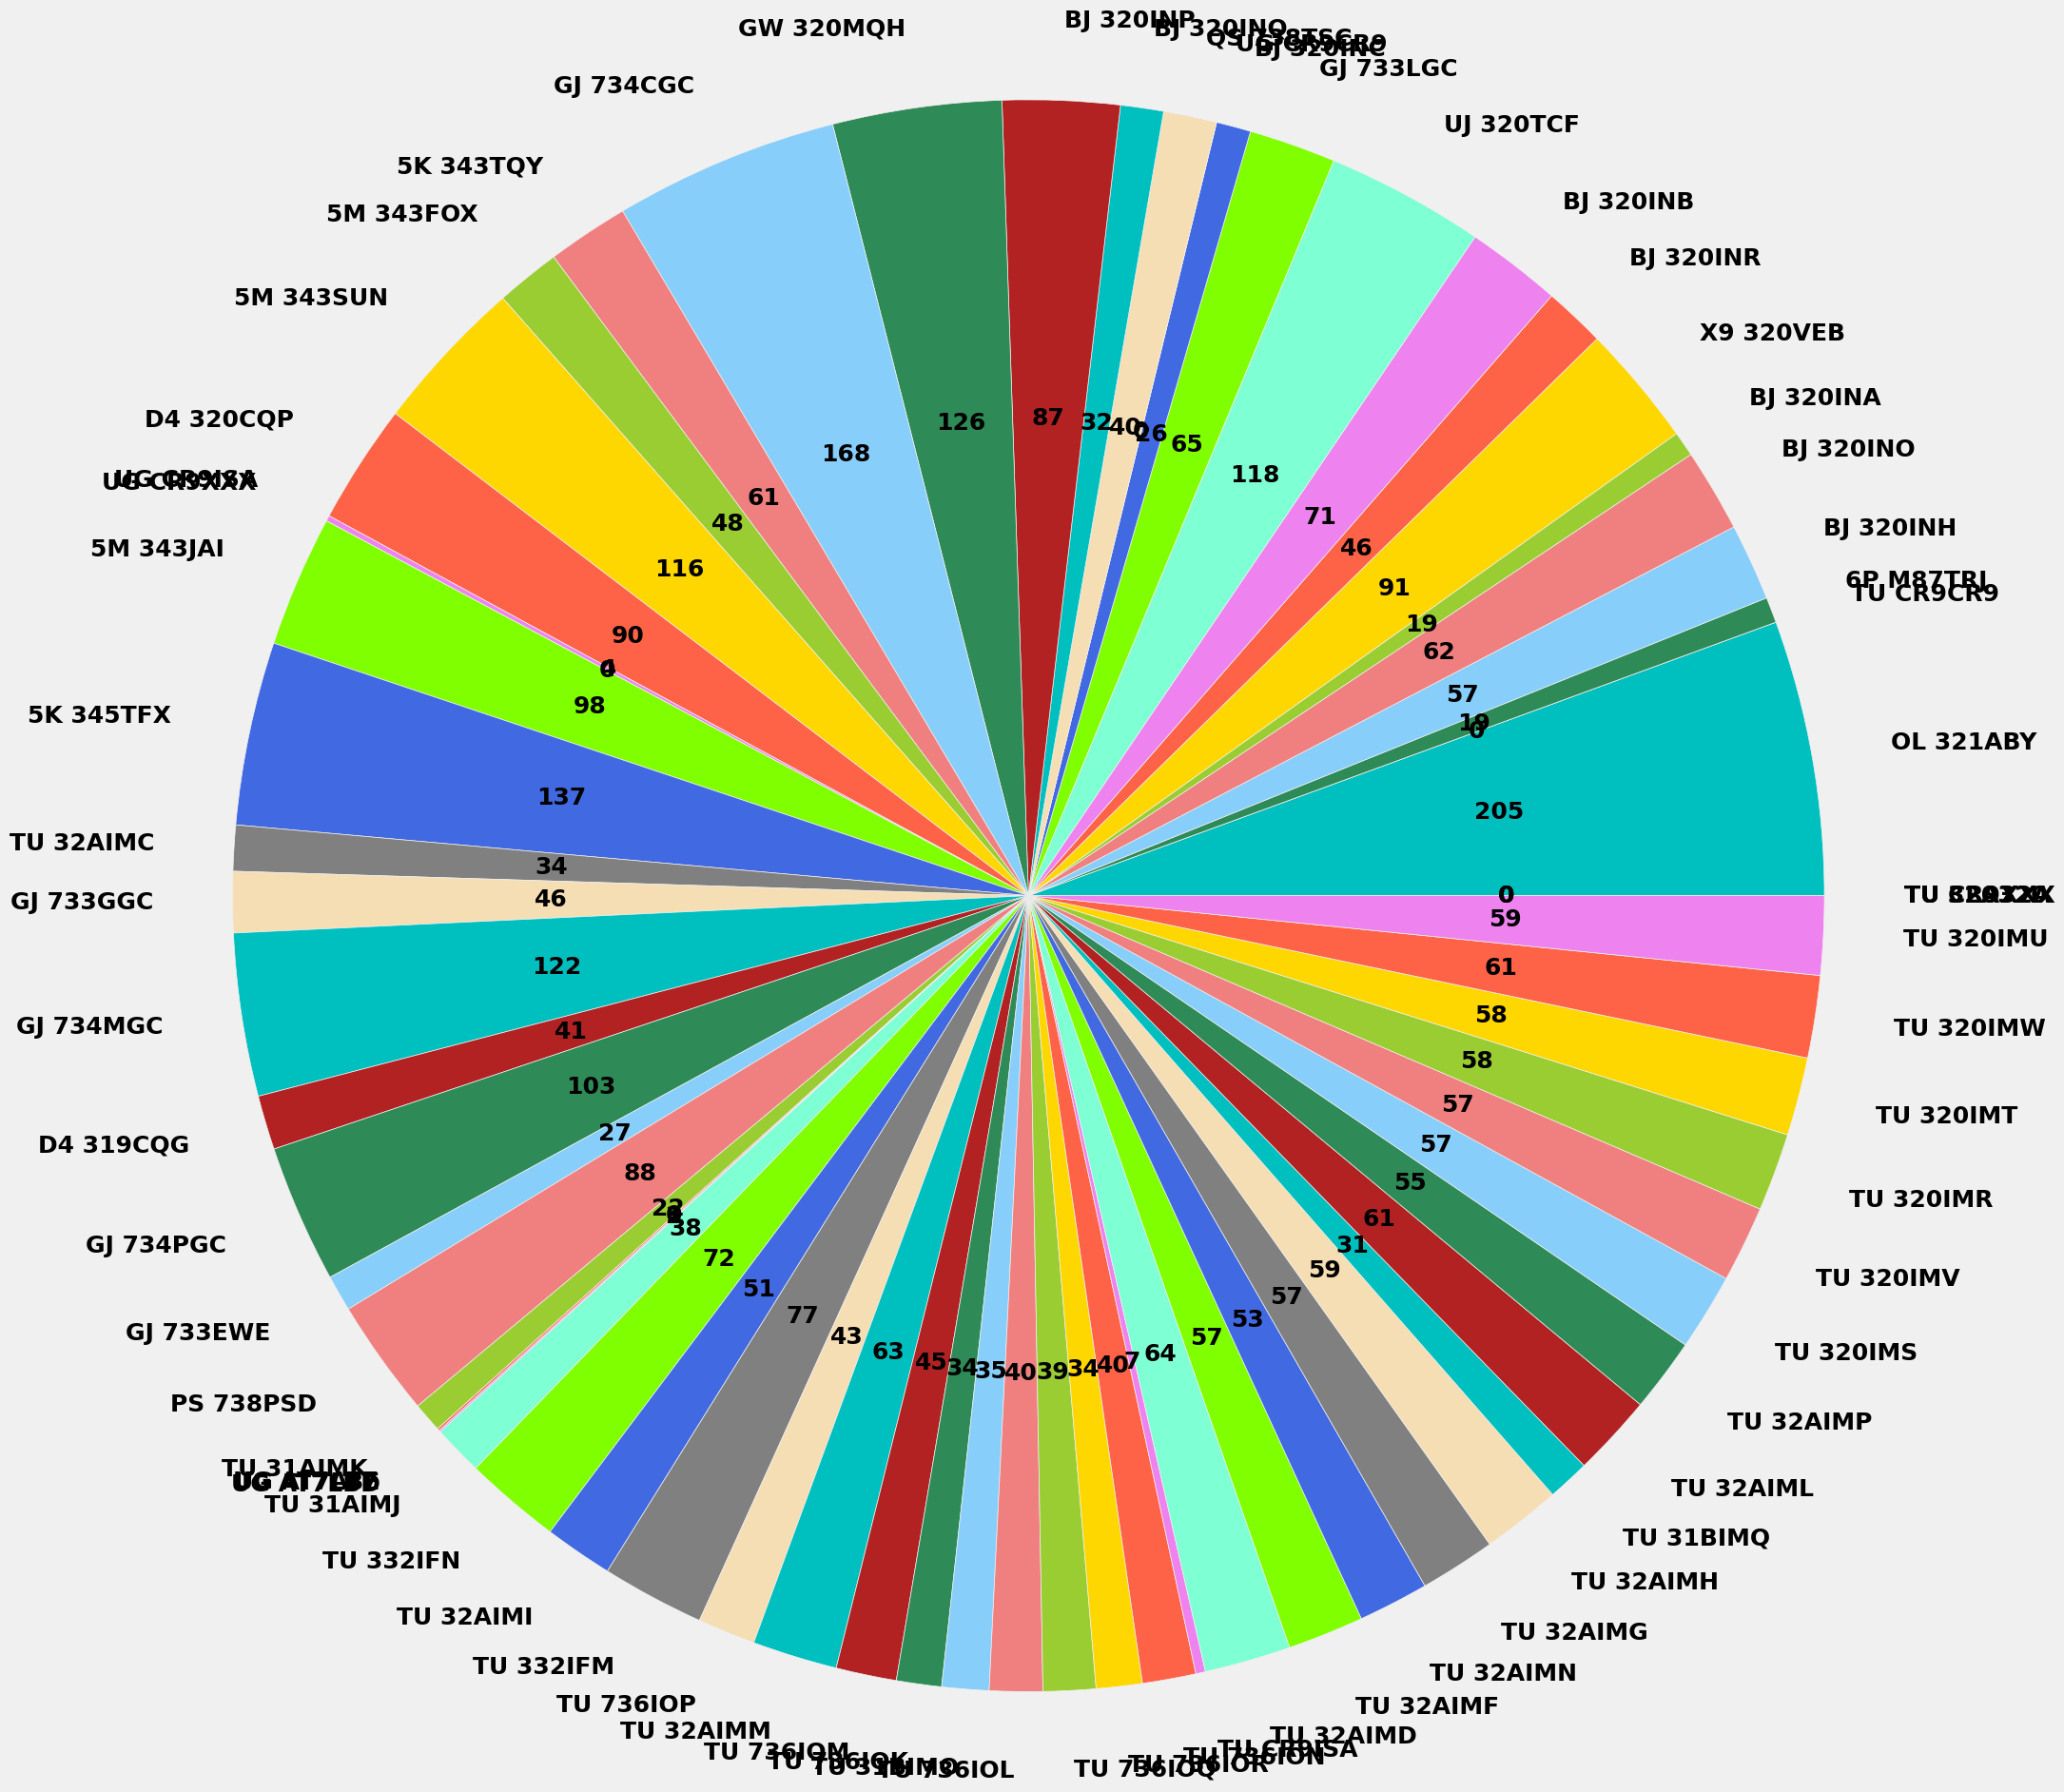

In [20]:
# ax2=fig.add_subplot(gs[0,1])
# Pie chart nº2: mean delay at departure
fig = plt.figure(1, figsize=(50,50))
ax2=fig.add_subplot(gs[0,0])
labels = [s for s in  global_stats.index]
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
patches, texts, autotexts = ax2.pie(sizes, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
ax2.axis('equal')
# ax2.set_title('Mean delay', bbox={'facecolor':'midnightblue', 'pad':5},
#               color='w', fontsize=24)
plt.show()

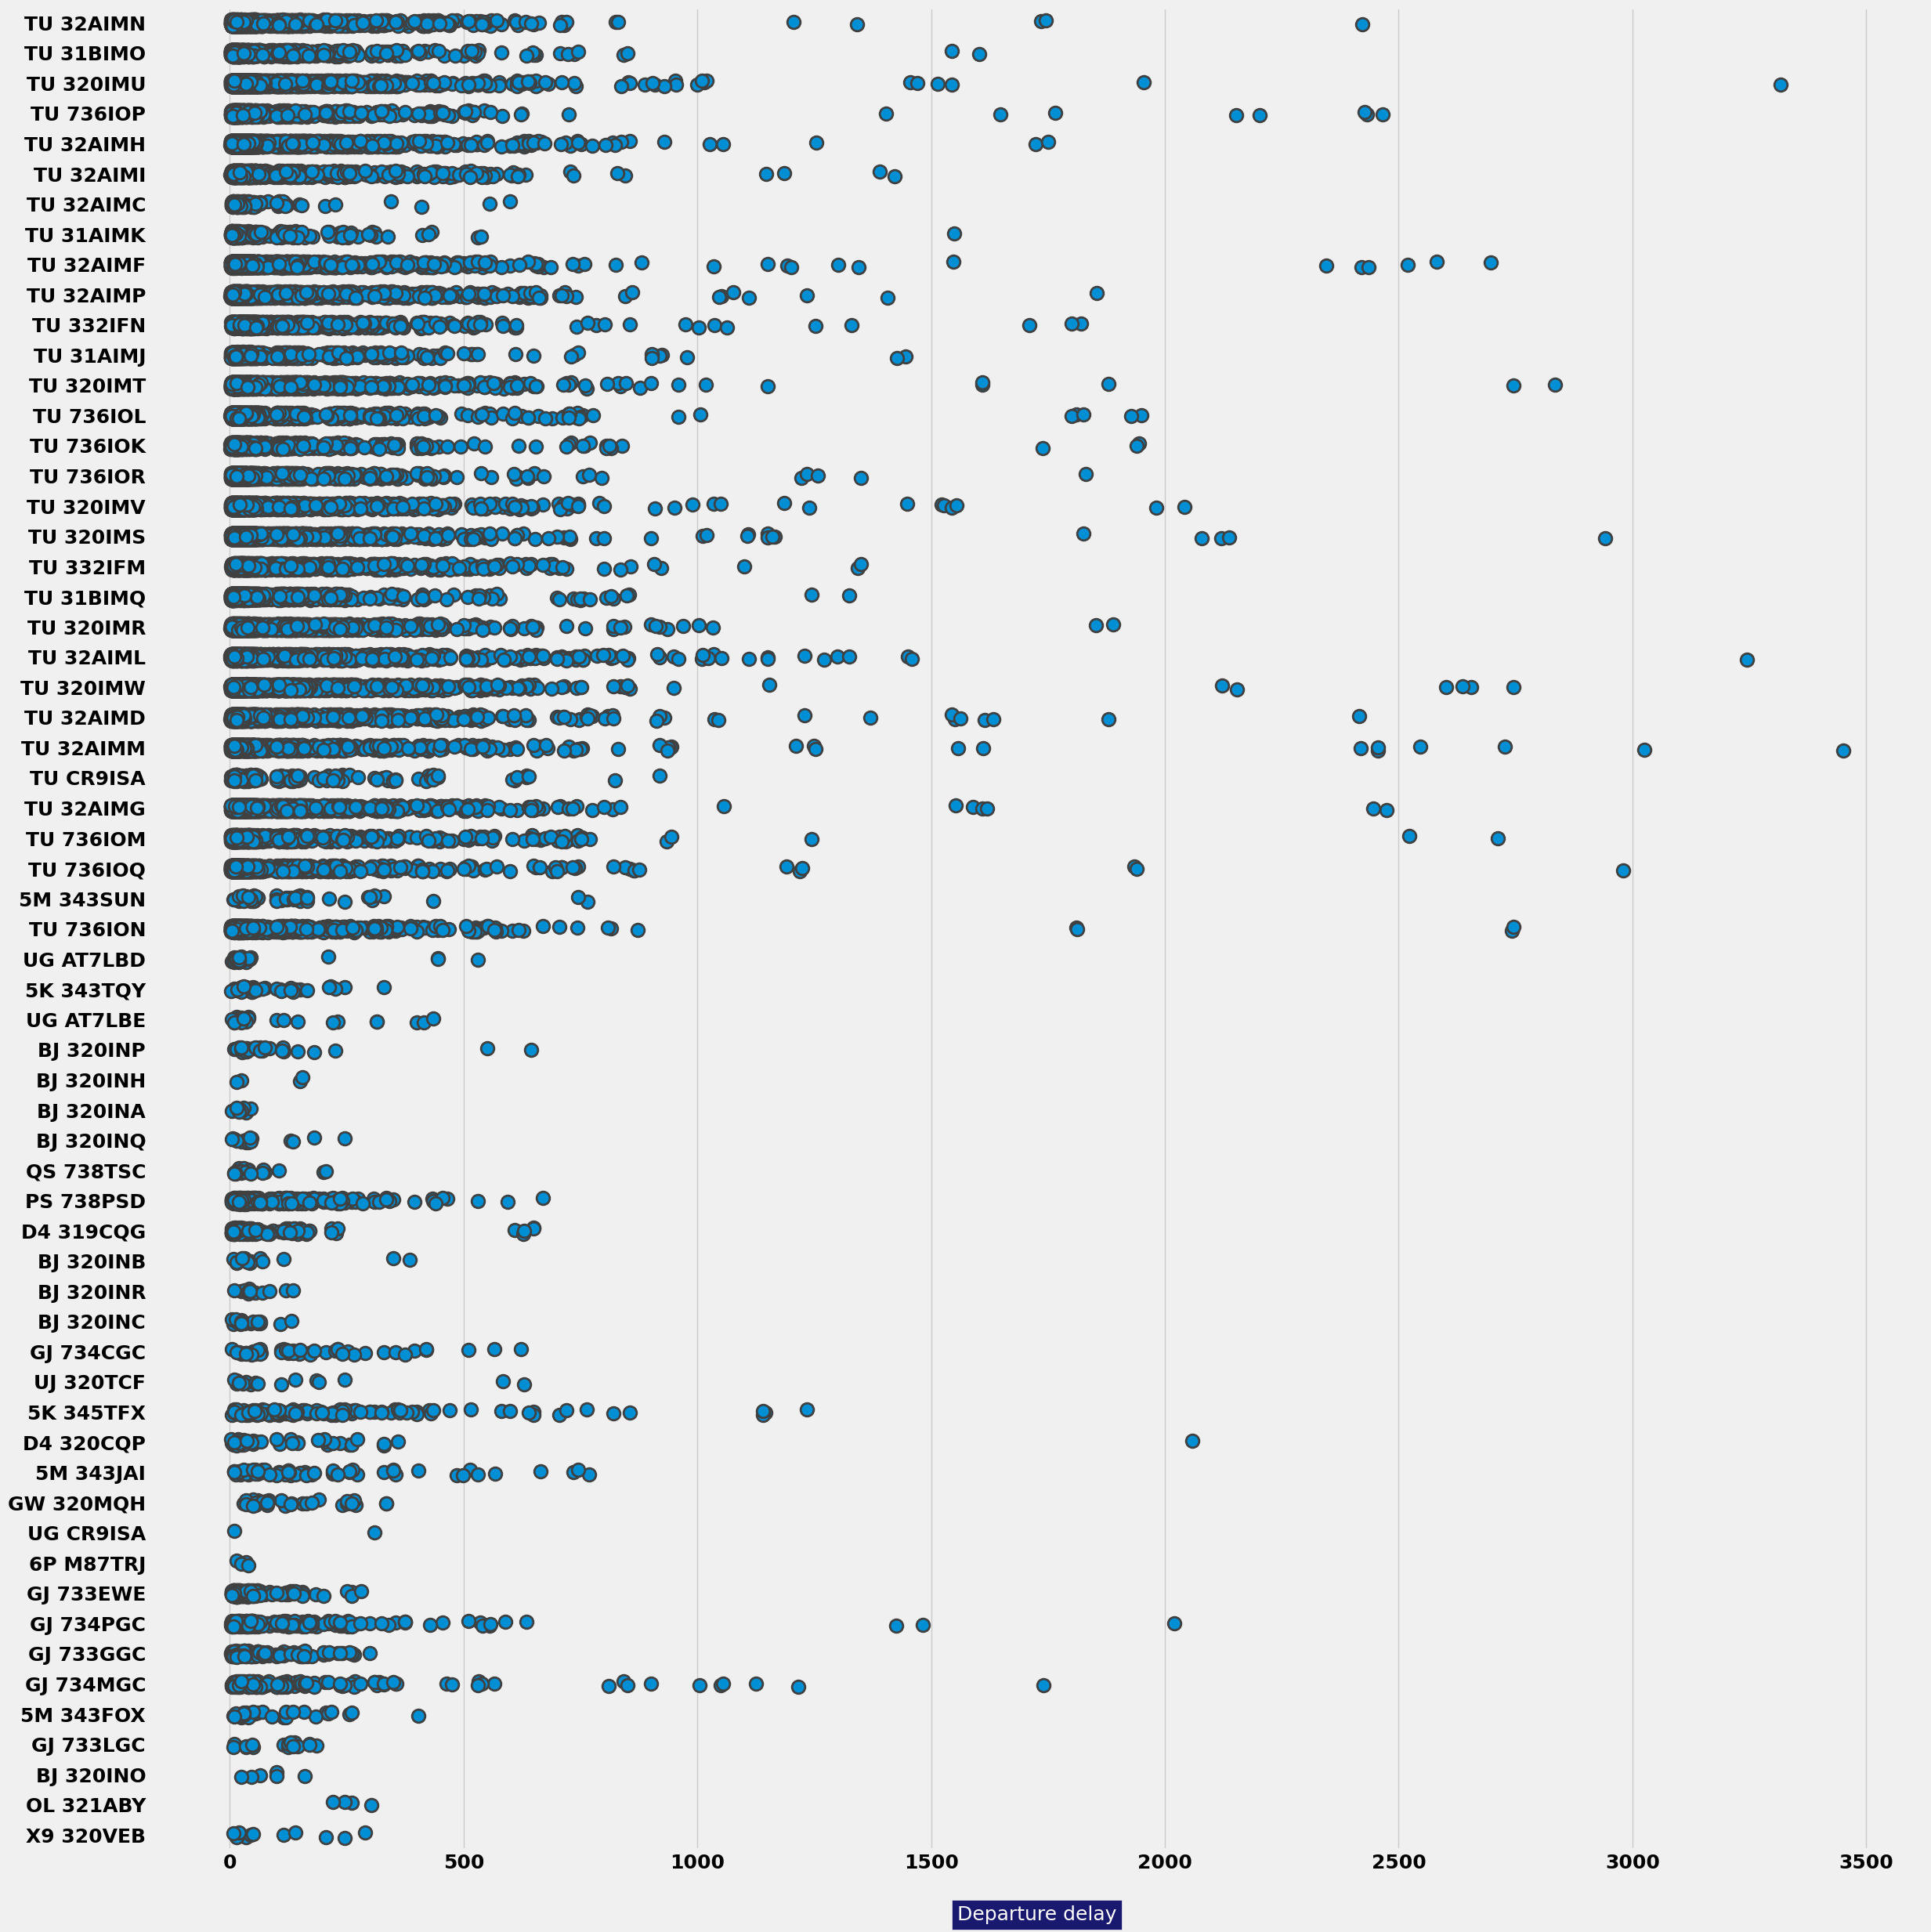

In [ ]:
fig = plt.figure(1, figsize=(25,25))
df2 = df.loc[:, ['AC', 'target']]
df2 = df2.drop(df2[df2.target == 0].index)
ax3 = sns.stripplot(x="target", y="AC", data=df2, size = 12, linewidth = 2,  jitter=True)
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=30)
ax3.yaxis.label.set_visible(False)
plt.tight_layout(w_pad=3)

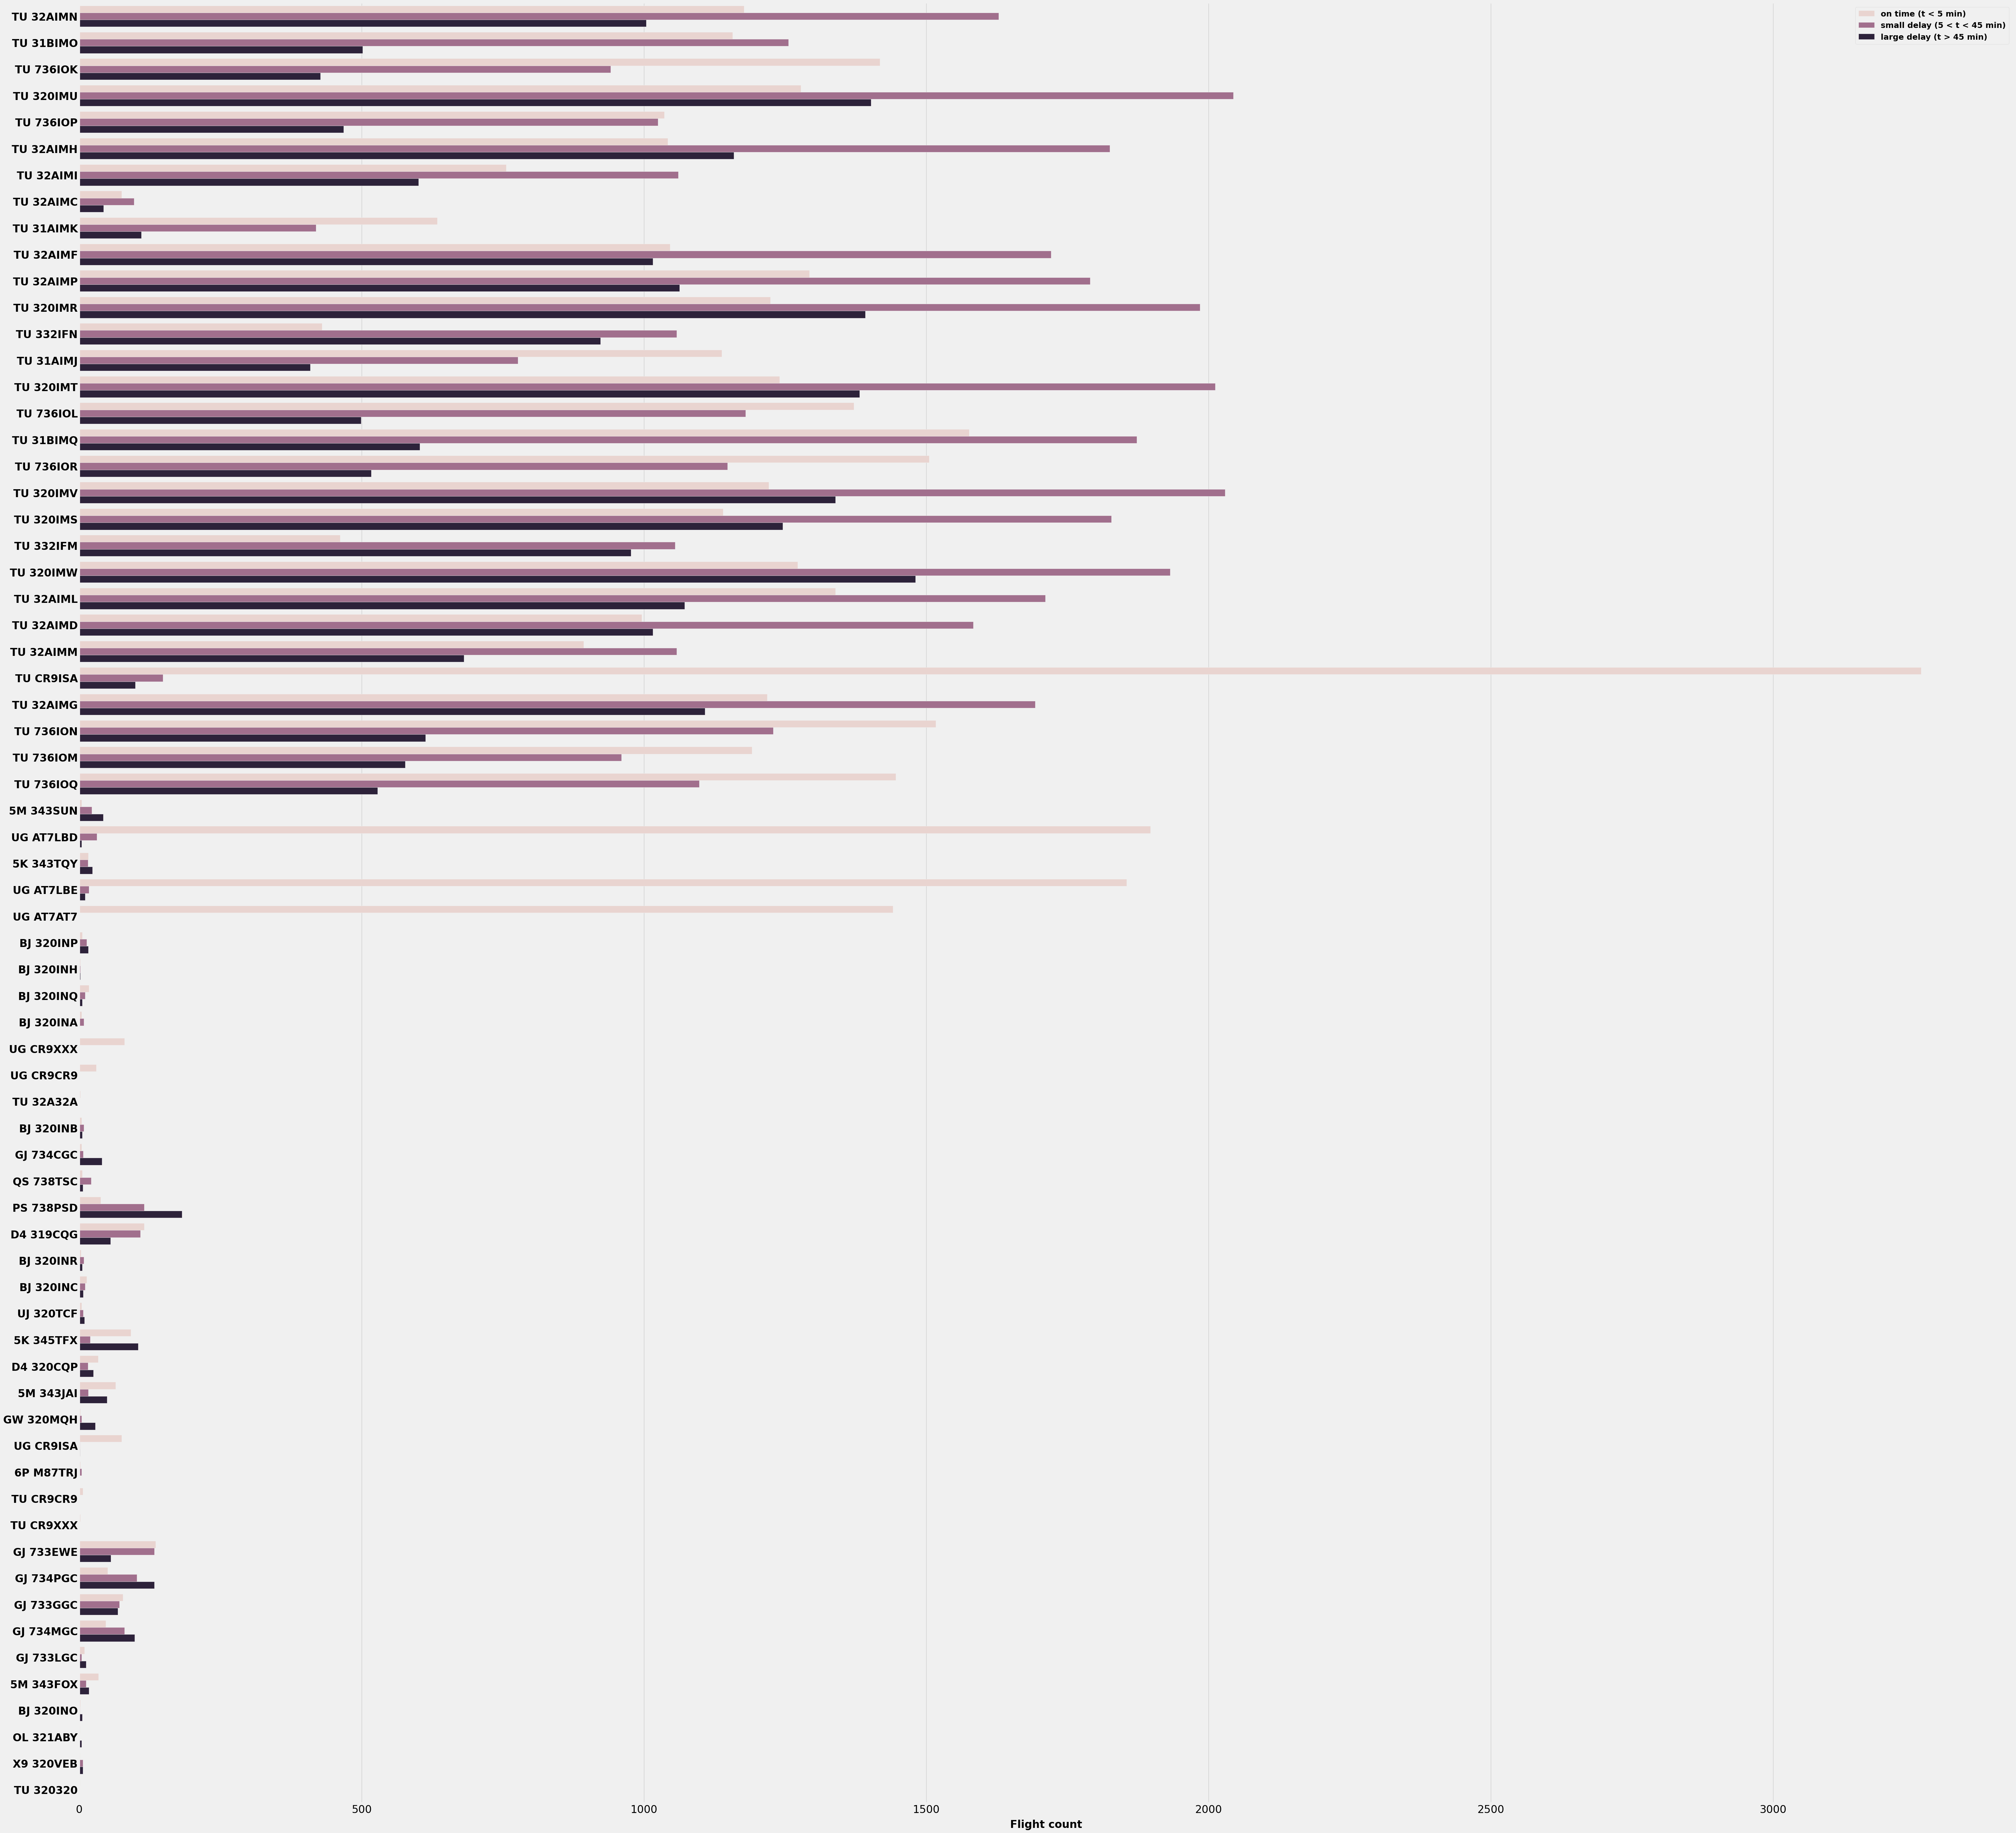

In [ ]:
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['target'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(70,70))
ax = sns.countplot(y="AC", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = df['AC'].unique().tolist()
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=24, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=24, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=24, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

<h2>Relationship between the origin airport and delays</h2>

In [21]:
print("Nb of airports: {}".format(len(df['DEPSTN'].unique())))

Nb of airports: 132


In [22]:
list_of_airpots = df['DEPSTN'].unique().tolist()
list_of_ac = df['AC'].unique().tolist()
origin_nb = dict()
for carrier in list_of_ac:
    liste_origin_airport = df[df['AC'] == carrier]['DEPSTN'].unique().tolist()
    origin_nb[carrier] = len(liste_origin_airport)

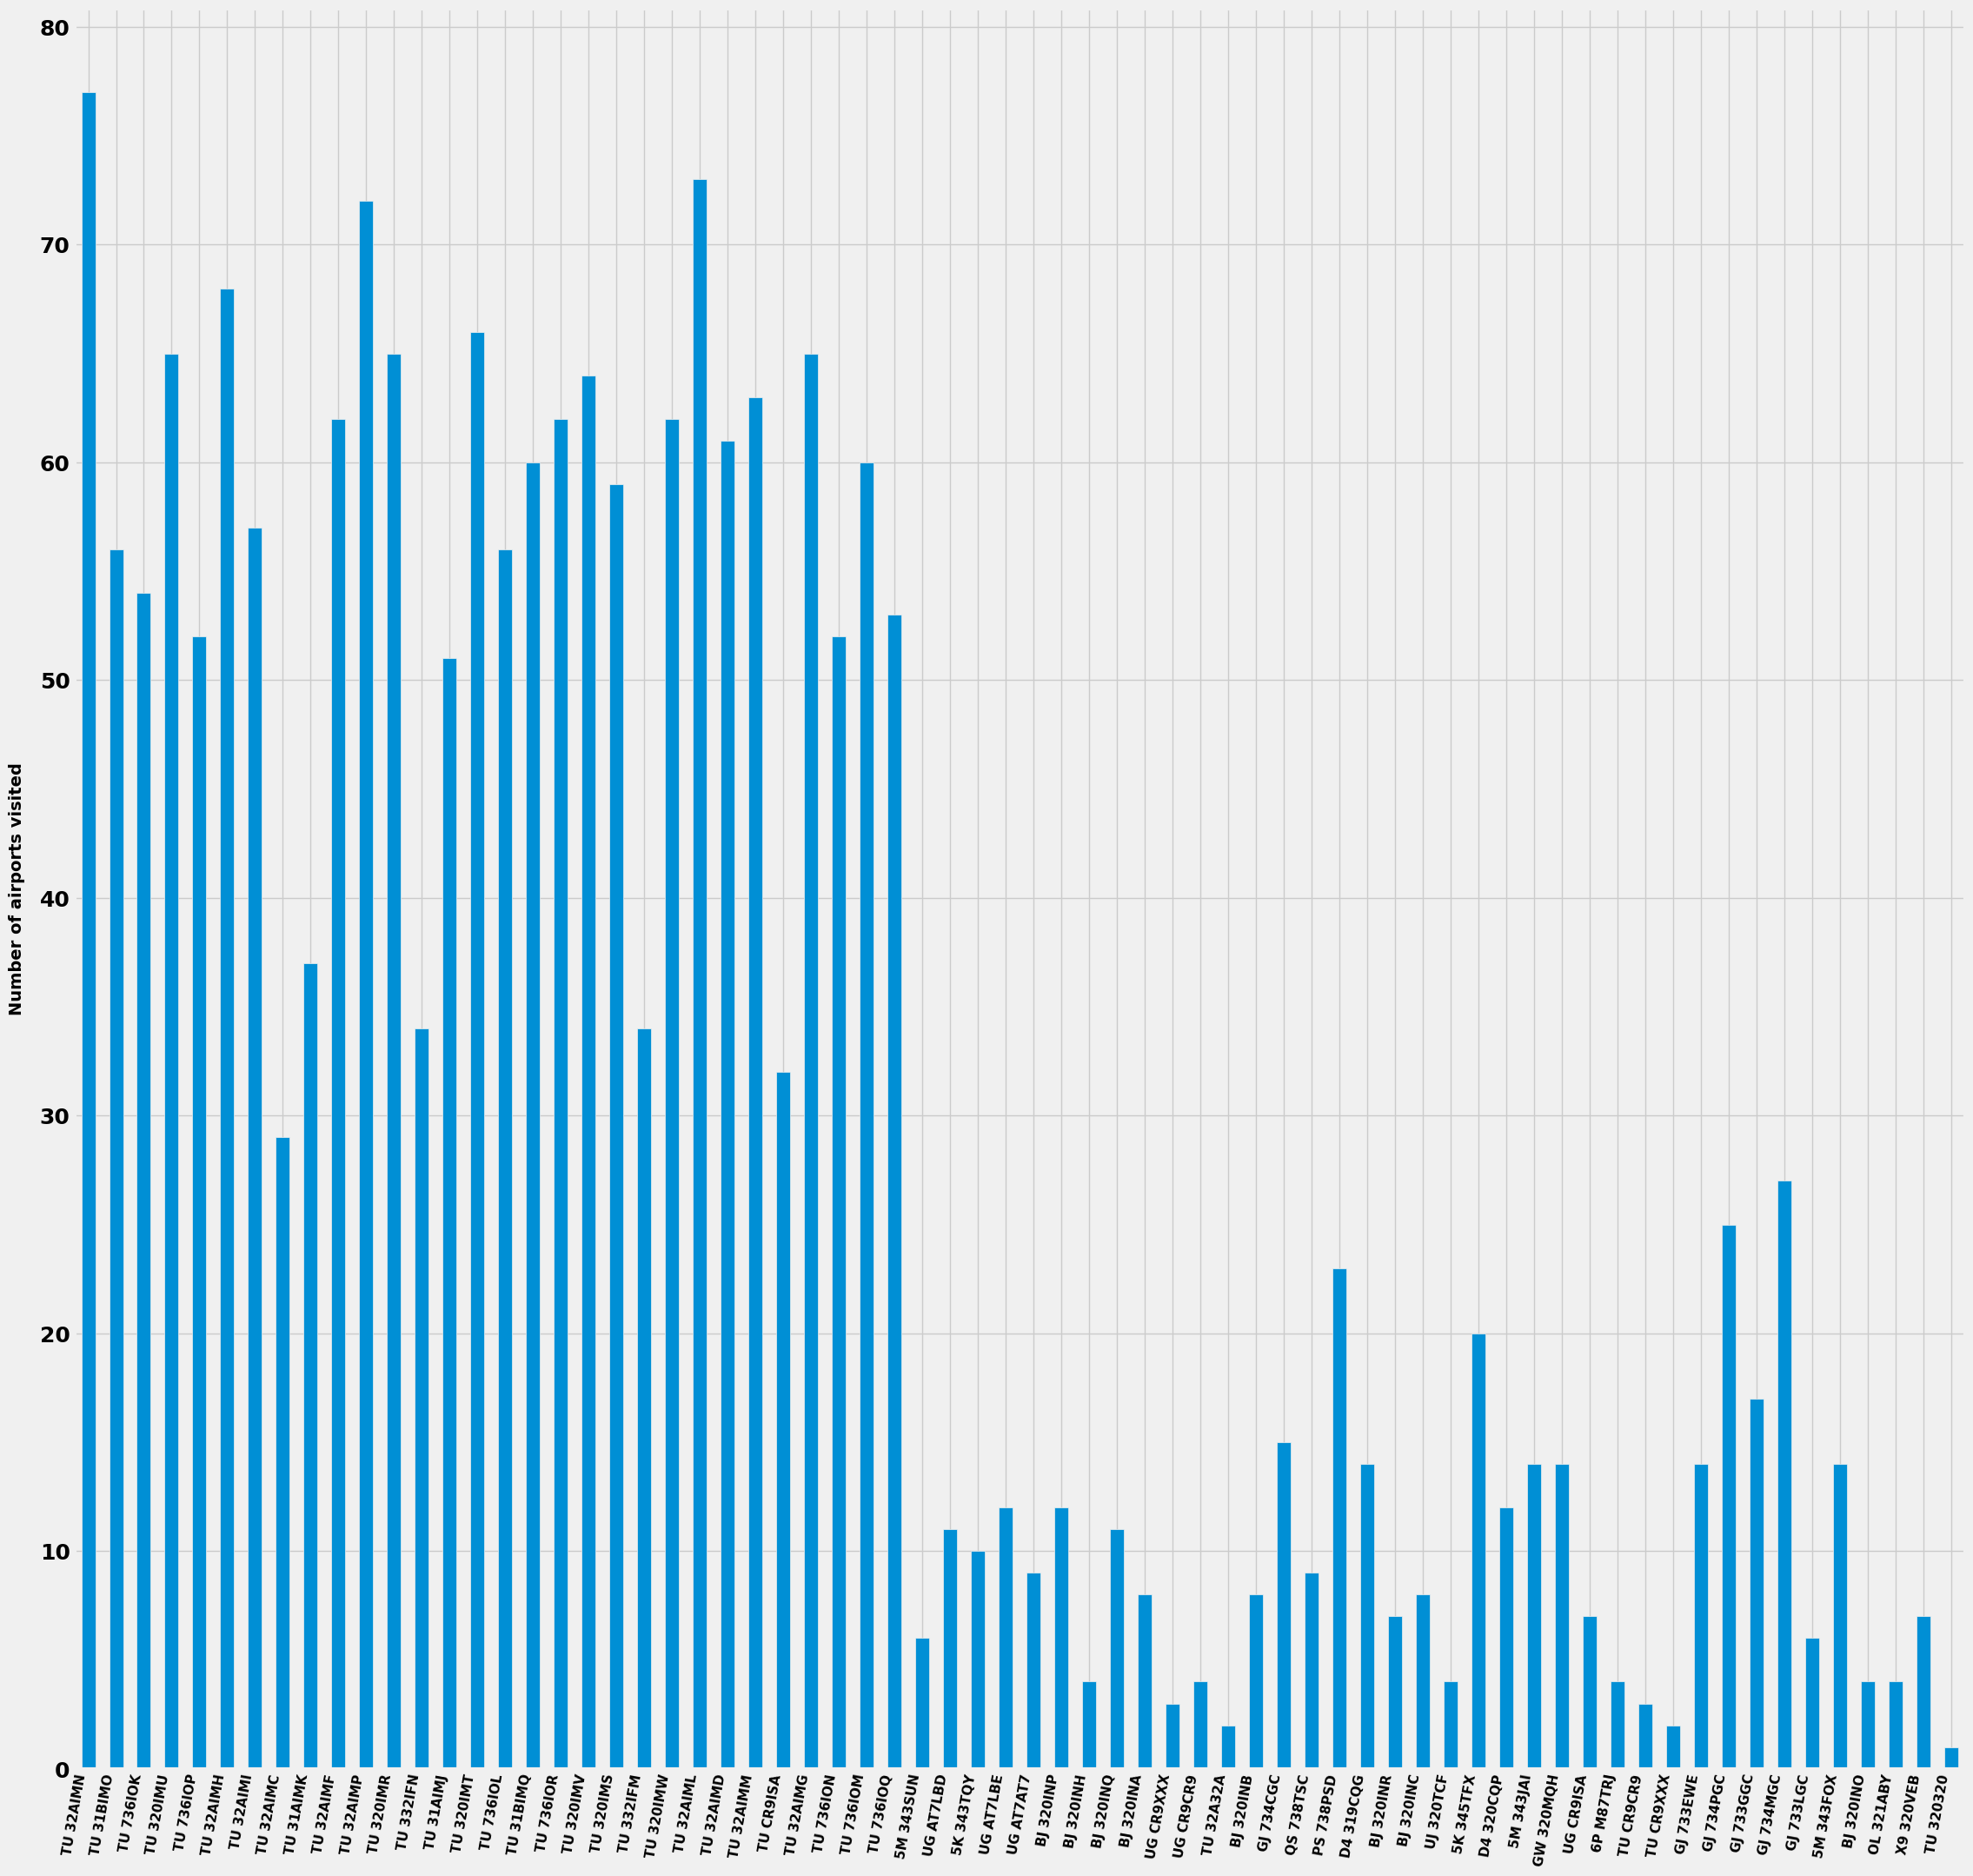

In [23]:
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (25,25))
labels = [x for x in list_of_ac]
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

**number of flights per year**

In [24]:
# df['month'] = pd.DatetimeIndex(df['DATOP']).month
df['year'] = pd.DatetimeIndex(df['DATOP']).year
df.head()

ID      DATOP    FLTID DEPSTN ARRSTN                 STD  \
0  train_id_0 2016-01-03  TU 0712    CMN    TUN 2016-01-03 10:30:00   
1  train_id_1 2016-01-13  TU 0757    MXP    TUN 2016-01-13 15:05:00   
2  train_id_2 2016-01-16  TU 0214    TUN    IST 2016-01-16 04:10:00   
3  train_id_3 2016-01-17  TU 0480    DJE    NTE 2016-01-17 14:10:00   
4  train_id_4 2016-01-17  TU 0338    TUN    ALG 2016-01-17 14:30:00   

                  STA STATUS         AC  target  year  
0 2016-01-03 12:55:00    ATA  TU 32AIMN   260.0  2016  
1 2016-01-13 16:55:00    ATA  TU 31BIMO    20.0  2016  
2 2016-01-16 06:45:00    ATA  TU 32AIMN     0.0  2016  
3 2016-01-17 17:00:00    ATA  TU 736IOK     0.0  2016  
4 2016-01-17 15:50:00    ATA  TU 320IMU    22.0  2016

In [25]:
flights_dict = dict()
ac_group = df.groupby('AC')
for x in list_of_ac:
    df_ac = ac_group.get_group(x)
    flights_dict[x] = df[df['AC'] == x]['year'].value_counts().to_dict()

In [26]:
flights_dict

{'TU 32AIMN': {2018: 1569, 2017: 1264, 2016: 976},
 'TU 31BIMO': {2016: 1265, 2018: 1125, 2017: 525},
 'TU 736IOK': {2018: 1363, 2016: 1316, 2017: 107},
 'TU 320IMU': {2018: 1644, 2017: 1602, 2016: 1478},
 'TU 736IOP': {2017: 1376, 2016: 1065, 2018: 88},
 'TU 32AIMH': {2017: 1575, 2018: 1469, 2016: 982},
 'TU 32AIMI': {2016: 1290, 2018: 999, 2017: 129},
 'TU 32AIMC': {2016: 213, 2017: 1, 2018: 1},
 'TU 31AIMK': {2016: 1081, 2017: 81, 2018: 1},
 'TU 32AIMF': {2018: 1441, 2016: 1322, 2017: 1020},
 'TU 32AIMP': {2017: 1580, 2018: 1412, 2016: 1154},
 'TU 320IMR': {2017: 1643, 2018: 1620, 2016: 1338},
 'TU 332IFN': {2018: 903, 2017: 811, 2016: 697},
 'TU 31AIMJ': {2017: 1212, 2016: 1110, 2018: 2},
 'TU 320IMT': {2017: 1638, 2018: 1554, 2016: 1442},
 'TU 736IOL': {2018: 1198, 2017: 1006, 2016: 847},
 'TU 31BIMQ': {2018: 1490, 2016: 1296, 2017: 1266},
 'TU 736IOR': {2018: 1160, 2016: 1104, 2017: 906},
 'TU 320IMV': {2018: 1610, 2017: 1563, 2016: 1416},
 'TU 320IMS': {2016: 1461, 2017: 1410, 2

In [27]:
# flights_dict
nbr_flights = pd.DataFrame.from_dict(flights_dict, orient='index')
nbr_flights.fillna(0, inplace=True)
# nbr_flights

In [28]:
nbr_flights.columns = ['flights_in_2018', 'flights_in_2017', 'flights_in_2016']

In [29]:
nbr_flights['flights_in_2016'] = nbr_flights['flights_in_2016'].astype(np.int64)
nbr_flights['flights_in_2017'] = nbr_flights['flights_in_2017'].astype(np.int64)
nbr_flights['flights_in_2018'] = nbr_flights['flights_in_2018'].astype(np.int64)
nbr_flights['total_flights'] = nbr_flights['flights_in_2016'] + nbr_flights['flights_in_2017'] + nbr_flights['flights_in_2018']
# nbr_flights

In [30]:
nbr_flights['total_flights'].unique().min()

1

In [31]:
nbr_flights['total_flights'].unique().max()

4724

In [32]:
nbr_flights['flights_in_2018'].unique()

array([1569, 1125, 1363, 1644,   88, 1469,  999,    1, 1441, 1412, 1620,
        903,    2, 1554, 1198, 1490, 1160, 1610, 1343,  958, 1513, 1450,
        399, 1529, 1432, 1176, 1226, 1391,  466,  314,  346,    4,    6,
         37,   12,   73,  324,  285,  216,  225,   25,   63,    8,    5,
         13,    0])

In [33]:
# add a variable describing the frequency of that AC's flights 3 levels (100 <, 100< < 200, >200) but per year
df['ac_frequency'] = 0
def define_frequency(nbr):
        if nbr<100:
            return 0

        else:
            if (nbr>100 and nbr<200):
                return 1
            else:
                return 2

In [34]:
for i in range(df.shape[0]):
    ac = df.loc[i, 'AC']
    year = df.loc[i, 'year']
    if year == 2016:
        freq_2016 = define_frequency(nbr_flights.loc[ac, 'flights_in_2016'])
        if freq_2016 !=0:
            df.at[i, 'ac_frequency'] = freq_2016
    else:
        if year == 2017:
            freq_2017 = define_frequency(nbr_flights.loc[ac, 'flights_in_2017'])
            if freq_2017 !=0:
                df.at[i, 'ac_frequency'] = freq_2017
        else:
            freq_2018 = define_frequency(nbr_flights.loc[ac, 'flights_in_2018'])
            if freq_2018 !=0:
                df.at[i, 'ac_frequency'] = freq_2018

In [35]:
airport_mean_delays = pd.DataFrame(pd.Series(df['DEPSTN'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in list_of_ac:
    df1 = df[df['AC'] == carrier]
    test = df1['target'].groupby(df['DEPSTN']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean']

In [36]:
airport_mean_delays

TU 32AIMN   TU 31BIMO  TU 736IOK   TU 320IMU  TU 736IOP  TU 32AIMH  \
0                                                                         
CMN  85.260870   50.381579   9.000000   38.070707  44.666667  71.457627   
MXP  72.928571   26.992248  63.384615   62.860465  57.235294  50.710526   
TUN  49.942475   28.700662  30.389868   49.561247  43.560468  51.437832   
DJE  30.598870  226.375000  27.783333   90.250000  32.969359  45.094340   
TLS  78.642857   51.259259  37.857143  100.208333  68.397590  60.269231   
..         ...         ...        ...         ...        ...        ...   
KRR        NaN         NaN        NaN         NaN        NaN        NaN   
RTM        NaN         NaN        NaN         NaN        NaN        NaN   
STR        NaN         NaN        NaN         NaN        NaN        NaN   
TPS        NaN         NaN        NaN         NaN        NaN        NaN   
CTA        NaN         NaN        NaN         NaN        NaN        NaN   

     TU 32AIMI   TU 32AIMC  TU 31AIMK   TU 32AIMF  TU 32AIMP  TU 320IMR  \
0                                                                         
CMN  47.586207   28.000000        NaN   67.052632  50.822222  56.076923   
MXP  43.166667   41.800000  23.333333   53.523256  65.434783  44.821053   
TUN  43.657443   23.869565  23.066667   50.034404  49.654404  50.237682   
DJE  59.439716  101.000000  14.707547   48.873494  37.144828  53.433333   
TLS  48.857143   41.000000  42.666667   65.114286  95.066667  53.214286   
..         ...         ...        ...         ...        ...        ...   
KRR        NaN         NaN        NaN         NaN   0.000000        NaN   
RTM        NaN         NaN        NaN  250.000000        NaN        NaN   
STR        NaN         NaN        NaN         NaN        NaN        NaN   
TPS        NaN         NaN        NaN         NaN        NaN        NaN   
CTA        NaN         NaN        NaN         NaN        NaN        NaN   

      TU 332IFN  TU 31AIMJ   TU 320IMT  TU 736IOL   TU 31BIMQ   TU 736IOR  \
0                                                                           
CMN   43.000000  79.500000   32.674157  64.714286   26.904762  109.333333   
MXP  182.000000  34.750000   77.836538  44.545455   28.526718   14.235294   
TUN   62.267396  37.324111   49.803931  43.330233   27.405510   38.188350   
DJE   23.714286  29.426446   62.226667  30.394958   32.533333   27.545108   
TLS  119.000000  86.416667  126.500000  60.355932   46.965517   42.911111   
..          ...        ...         ...        ...         ...         ...   
KRR         NaN        NaN         NaN        NaN         NaN         NaN   
RTM         NaN        NaN  327.000000        NaN  792.500000         NaN   
STR         NaN        NaN         NaN        NaN         NaN         NaN   
TPS         NaN        NaN         NaN        NaN         NaN         NaN   
CTA         NaN        NaN         NaN        NaN         NaN         NaN   

      TU 320IMV   TU 320IMS  TU 332IFM   TU 320IMW   TU 32AIML   TU 32AIMD  \
0                                                                            
CMN   32.632000   28.419048        NaN   44.388350   72.697674   66.044776   
MXP   52.253012   71.246575   0.000000   55.670213   70.448718   66.627451   
TUN   47.323450   46.402494  69.798186   53.605275   53.322328   57.508696   
DJE  155.208333   66.186047  57.866667  117.305556   58.195876   45.788177   
TLS   78.142857  104.000000  40.000000  101.133333   54.814815  106.880000   
..          ...         ...        ...         ...         ...         ...   
KRR         NaN         NaN        NaN         NaN         NaN         NaN   
RTM  329.000000         NaN        NaN         NaN  850.000000         NaN   
STR         NaN         NaN        NaN         NaN         NaN         NaN   
TPS         NaN         NaN        NaN         NaN         NaN         NaN   
CTA         NaN         NaN        NaN         NaN         NaN         NaN   

      TU 32AIMM  ...  GJ 734CGC  QS 

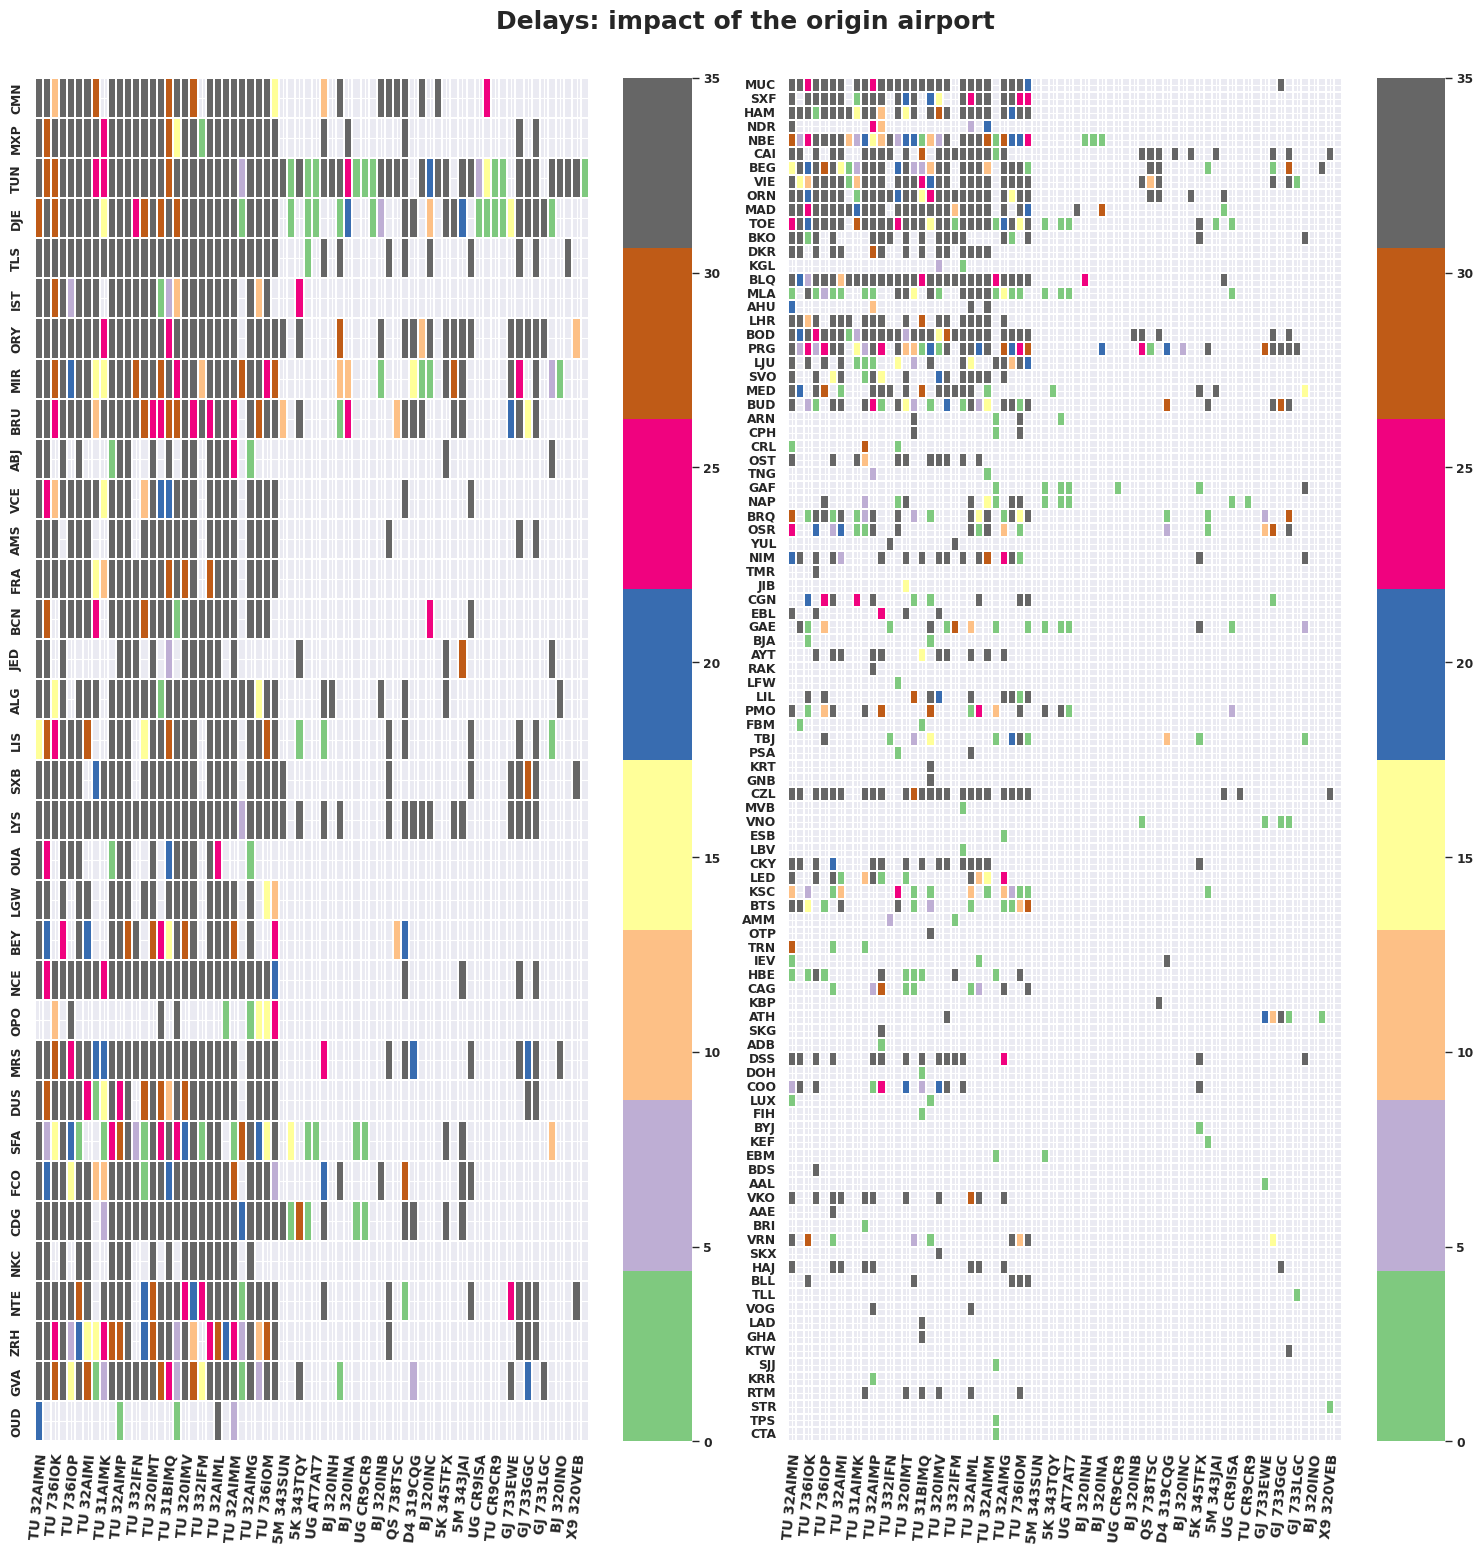

In [37]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(15,15))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:34,:]
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)
subset = airport_mean_delays.iloc[34:,:]
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()

**As we can see the departure airport has a great impact on the delay we can see the dominance of large delays in a lot of airports like LYS and SXB in the left panel**

-> There is a high variability in average delays, both between the different airports but also between the different airlines. This is important because it implies that in order to accurately model the delays, it will be necessary to adopt a model that is specific to the company and the home airport .

In [38]:
df.head()

ID      DATOP    FLTID DEPSTN ARRSTN                 STD  \
0  train_id_0 2016-01-03  TU 0712    CMN    TUN 2016-01-03 10:30:00   
1  train_id_1 2016-01-13  TU 0757    MXP    TUN 2016-01-13 15:05:00   
2  train_id_2 2016-01-16  TU 0214    TUN    IST 2016-01-16 04:10:00   
3  train_id_3 2016-01-17  TU 0480    DJE    NTE 2016-01-17 14:10:00   
4  train_id_4 2016-01-17  TU 0338    TUN    ALG 2016-01-17 14:30:00   

                  STA STATUS         AC  target  year  ac_frequency  
0 2016-01-03 12:55:00    ATA  TU 32AIMN   260.0  2016             2  
1 2016-01-13 16:55:00    ATA  TU 31BIMO    20.0  2016             2  
2 2016-01-16 06:45:00    ATA  TU 32AIMN     0.0  2016             2  
3 2016-01-17 17:00:00    ATA  TU 736IOK     0.0  2016             2  
4 2016-01-17 15:50:00    ATA  TU 320IMU    22.0  2016             2

<h2> Feature Engineering </h2>

Label encoding

In [39]:
df = pd.read_csv('/content/drive/MyDrive/ML_project/Train_interm.csv')

In [40]:
df.head()

ID       DATOP    FLTID DEPSTN ARRSTN                  STD  \
0  train_id_0  2016-01-03  TU 0712    CMN    TUN  2016-01-03 10:30:00   
1  train_id_1  2016-01-13  TU 0757    MXP    TUN  2016-01-13 15:05:00   
2  train_id_2  2016-01-16  TU 0214    TUN    IST  2016-01-16 04:10:00   
3  train_id_3  2016-01-17  TU 0480    DJE    NTE  2016-01-17 14:10:00   
4  train_id_4  2016-01-17  TU 0338    TUN    ALG  2016-01-17 14:30:00   

                   STA STATUS         AC  target  DELAY_LEVEL  year  \
0  2016-01-03 12:55:00    ATA  TU 32AIMN   260.0            2  2016   
1  2016-01-13 16:55:00    ATA  TU 31BIMO    20.0            1  2016   
2  2016-01-16 06:45:00    ATA  TU 32AIMN     0.0            0  2016   
3  2016-01-17 17:00:00    ATA  TU 736IOK     0.0            0  2016   
4  2016-01-17 15:50:00    ATA  TU 320IMU    22.0            1  2016   

   ac_frequency  
0             2  
1             2  
2             2  
3             2  
4             2

In [41]:
df['trajectory'] = df['DEPSTN'] + '-' + df['ARRSTN']
df_test['trajectory'] = df_test['DEPSTN'] + '-' + df_test['ARRSTN']

In [42]:
df['trajectory'].nunique()

741

In [43]:
df['DATOP']= pd.to_datetime(df['DATOP'])

In [44]:
df['month'] =df['DATOP'].dt.month
df['day'] = df['DATOP'].dt.day
df['day_of_week'] = df['DATOP'].dt.dayofweek
df['year'] = df['DATOP'].dt.year
df['week_of_year'] = df['DATOP'].dt.isocalendar().week

In [45]:
df_test['DATOP']= pd.to_datetime(df_test['DATOP'])

In [46]:
df_test['month'] = df_test['DATOP'].dt.month
df_test['day'] = df_test['DATOP'].dt.day
df_test['day_of_week'] = df_test['DATOP'].dt.dayofweek
df_test['year'] = df_test['DATOP'].dt.year
df_test['week_of_year'] = df_test['DATOP'].dt.isocalendar().week

In [47]:
# Adding a week of month variable
data = [df, df_test]
for dataset in data:
    dataset.loc[ dataset['day'] <= 7, 'week_of_month'] = 0
    dataset.loc[(dataset['day'] > 7) & (dataset['day'] <= 14), 'week_of_month'] = 1
    dataset.loc[(dataset['day'] > 14) & (dataset['day'] <= 21), 'week_of_month'] = 2
    dataset.loc[(dataset['day'] > 21) & (dataset['day'] <= 28), 'week_of_month'] = 3
    dataset.loc[(dataset['day'] > 28) & (dataset['day'] <= 31), 'week_of_month'] = 4
    dataset['week_of_month'] = dataset['week_of_month'].astype(int)

In [48]:
# Adding a season column depicting the season the flight has taken place in
data = [df, df_test]
for dataset in data:
    dataset.loc[ (dataset['month'] < 3) | (dataset['month'] == 12), 'season'] = 0
    dataset.loc[(dataset['month'] >= 3) & (dataset['month'] < 6), 'season'] = 1
    dataset.loc[(dataset['month'] >= 6) & (dataset['month'] < 9), 'season'] = 2
    dataset.loc[(dataset['month'] >= 9) & (dataset['month'] < 12), 'season'] = 3
    dataset['season'] = dataset['season'].astype(int)

In [49]:
df['dep_hour'] = pd.DatetimeIndex(df['STD']).hour
df_test['dep_hour'] = pd.DatetimeIndex(df_test['STD']).hour


df['arr_hour'] = pd.DatetimeIndex(df['STA']).hour
df_test['arr_hour'] = pd.DatetimeIndex(df_test['STA']).hour

In [50]:
df['dep_minute'] = pd.DatetimeIndex(df['STD']).minute
df_test['dep_minute'] = pd.DatetimeIndex(df_test['STD']).minute

df['arr_minute'] = pd.DatetimeIndex(df['STA']).minute
df_test['arr_minute'] = pd.DatetimeIndex(df_test['STA']).minute

In [51]:
df['STA'] = pd.to_datetime(df['STA'])
df['STD'] = pd.to_datetime(df['STD'])

In [52]:
df['flight_duration_sec'] = (df['STA'] - df['STD']).values.astype(np.int64) // 10 ** 9
df_test['flight_duration_sec'] = (df_test['STA'] - df_test['STD']).values.astype(np.int64) // 10 ** 9

In [53]:
df['flight_duration_hours'] = df['arr_hour'] - df['dep_hour']
df_test['flight_duration_hours'] = df_test['arr_hour'] - df_test['dep_hour']

df['flight_duration_minutes'] = (df['flight_duration_sec'] / 60).astype(np.int64)
df_test['flight_duration_minutes'] = (df_test['flight_duration_sec'] / 60).astype(np.int64)

In [54]:
data = [df, df_test]
for dataset in data:
    dataset.loc[ (dataset['dep_hour'] < 12) , 'dep_hour_AM_PM'] = 0
    dataset.loc[(dataset['dep_hour'] >= 12) , 'dep_hour_AM_PM'] = 1
    dataset['dep_hour_AM_PM'] = dataset['dep_hour_AM_PM'].astype(int)

    dataset.loc[ (dataset['arr_hour'] < 12) , 'arr_hour_AM_PM'] = 0
    dataset.loc[(dataset['arr_hour'] >= 12) , 'arr_hour_AM_PM'] = 1
    dataset['arr_hour_AM_PM'] = dataset['arr_hour_AM_PM'].astype(int)

In [55]:
df['S_dep_hour'] = np.sin(2*np.pi*df['dep_hour']/24)
df['C_dep_hour'] = np.cos(2*np.pi*df['dep_hour']/24)
df_test['S_dep_hour'] = np.sin(2*np.pi*df_test['dep_hour']/24)
df_test['C_dep_hour'] = np.cos(2*np.pi*df_test['dep_hour']/24)


df['S_arr_hour'] = np.sin(2*np.pi*df['arr_hour']/24)
df['C_arr_hour'] = np.cos(2*np.pi*df['arr_hour']/24)
df_test['S_arr_hour'] = np.sin(2*np.pi*df_test['arr_hour']/24)
df_test['C_arr_hour'] = np.cos(2*np.pi*df_test['arr_hour']/24)

In [56]:
# '2016-01-03'.strftime('%j')
data = [df, df_test]
for dataset in data:
    for i in range(dataset.shape[0]):
        dataset.loc[i, 'day_of_year'] = int(dataset.loc[i, 'DATOP'].strftime('%j'))
# int(df['DATOP'].datetime.strftime('%j'))

In [57]:
df.head()

ID      DATOP    FLTID DEPSTN ARRSTN                 STD  \
0  train_id_0 2016-01-03  TU 0712    CMN    TUN 2016-01-03 10:30:00   
1  train_id_1 2016-01-13  TU 0757    MXP    TUN 2016-01-13 15:05:00   
2  train_id_2 2016-01-16  TU 0214    TUN    IST 2016-01-16 04:10:00   
3  train_id_3 2016-01-17  TU 0480    DJE    NTE 2016-01-17 14:10:00   
4  train_id_4 2016-01-17  TU 0338    TUN    ALG 2016-01-17 14:30:00   

                  STA STATUS         AC  target  DELAY_LEVEL  year  \
0 2016-01-03 12:55:00    ATA  TU 32AIMN   260.0            2  2016   
1 2016-01-13 16:55:00    ATA  TU 31BIMO    20.0            1  2016   
2 2016-01-16 06:45:00    ATA  TU 32AIMN     0.0            0  2016   
3 2016-01-17 17:00:00    ATA  TU 736IOK     0.0            0  2016   
4 2016-01-17 15:50:00    ATA  TU 320IMU    22.0            1  2016   

   ac_frequency trajectory  month  day  day_of_week  week_of_year  \
0             2    CMN-TUN      1    3            6            53   
1             2    MXP-TUN      1   13            2             2   
2             2    TUN-IST      1   16            5             2   
3             2    DJE-NTE      1   17            6             2   
4             2    TUN-ALG      1   17            6             2   

   week_of_month  season  dep_hour  arr_hour  dep_minute  arr_minute  \
0              0       0        10        12          30          55   
1              1       0        15        16           5          55   
2              2       0         4         6          10          45   
3              2       0        14        17          10           0   
4              2       0        14        15          30          50   

   flight_duration_sec  flight_duration_hours  flight_duration_minutes  \
0                 8700                      2                      145   
1                 6600                      1                      110   
2                 9300                      2                      155   
3                10200                      3                      170   
4                 4800                      1                       80   

   dep_hour_AM_PM  arr_hour_AM_PM  S_dep_hour  C_dep_hour    S_arr_hour  \
0               0               1    0.500000   -0.866025  1.224647e-16   
1               1               1   -0.707107   -0.707107 -8.660254e-01   
2               0               0    0.866025    0.500000  1.000000e+00   
3               1               1   -0.500000   -0.866025 -9.659258e-01   
4               1               1   -0.500000   -0.866025 -7.071068e-01   

     C_arr_hour  day_of_year  
0 -1.000000e+00          3.0  
1 -5.000000e-01         13.0  
2  6.123234e-17         16.0  
3 -2.588190e-01         17.0  
4 -7.071068e-01         17.0

In [ ]:
# corrmat = df.corr()
# top_corr_features = corrmat.index
# plt.figure(figsize=(20,20))
# #plot heat map
# g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [58]:
df.shape

(107833, 34)

In [74]:
df = pd.read_csv('/content/drive/MyDrive/ML_project/Train_clean.csv')

In [75]:
# we shuffle data
df = df.sample(frac=1).reset_index(drop=True)

In [76]:
df.head()

ID       DATOP    FLTID DEPSTN ARRSTN                  STD  \
0  train_id_83859  2018-04-22  TU 0745    FRA    TUN  2018-04-22 10:20:00   
1  train_id_19332  2016-06-24  TU 0472    TUN    VCE  2016-06-24 13:15:00   
2  train_id_42609  2017-06-15  TU 0757    MXP    TUN  2017-06-15 11:10:00   
3  train_id_86936  2018-05-19  TU 0681    MRS    MIR  2018-05-19 19:10:00   
4  train_id_24946  2016-11-05  TU 0930    TUN    MRS  2016-11-05 07:25:00   

                   STA STATUS         AC  target  DELAY_LEVEL  year  \
0  2018-04-22 12:40:00    ATA  TU 32AIMH   240.0            2  2018   
1  2016-06-24 14:55:00    ATA  TU 320IMV     7.0            1  2016   
2  2017-06-15 13:00:00    ATA  TU 320IMW    15.0            1  2017   
3  2018-05-19 20:55:00    ATA  TU 736IOL     0.0            0  2018   
4  2016-11-05 09:00:00    ATA  TU 320IMW    17.0            1  2016   

   ac_frequency trajectory  month  day  day_of_week  week_of_year  \
0             2    FRA-TUN      4   22            6            16   
1             2    TUN-VCE      6   24            4            25   
2             2    MXP-TUN      6   15            3            24   
3             2    MRS-MIR      5   19            5            20   
4             2    TUN-MRS     11    5            5            44   

   week_of_month  season  dep_hour  arr_hour  dep_minute  arr_minute  \
0              3       1        10        12          20          40   
1              3       2        13        14          15          55   
2              2       2        11        13          10           0   
3              2       1        19        20          10          55   
4              0       3         7         9          25           0   

   flight_duration_sec  flight_duration_hours  flight_duration_minutes  \
0                 8400                      2                      140   
1                 6000                      1                      100   
2                 6600                      2                      110   
3                 6300                      1                      105   
4                 5700                      2                       95   

   dep_hour_AM_PM  arr_hour_AM_PM  S_dep_hour  C_dep_hour    S_arr_hour  \
0               0               1    0.500000   -0.866025  1.224647e-16   
1               1               1   -0.258819   -0.965926 -5.000000e-01   
2               0               1    0.258819   -0.965926 -2.588190e-01   
3               1               1   -0.965926    0.258819 -8.660254e-01   
4               0               0    0.965926   -0.258819  7.071068e-01   

   C_arr_hour  day_of_year  
0   -1.000000        112.0  
1   -0.866025        176.0  
2   -0.965926        166.0  
3    0.500000        139.0  
4   -0.707107        310.0

In [ ]:
# !!!! only in case df is read from the file we need to convert the types back to datetime objects
# df['STD'] =  pd.to_datetime(df['STD'], format='%Y-%m-%d %H:%M:%S')
# df['STA'] =  pd.to_datetime(df['STA'], format='%Y-%m-%d %H:%M:%S')
# df['DATOP'] =  pd.to_datetime(df['DATOP'], format='%Y-%m-%d')

In [ ]:
df.to_csv('/content/drive/MyDrive/ML_project/Train_clean.csv', index=False)

In [77]:
df.columns

Index(['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
       'AC', 'target', 'DELAY_LEVEL', 'year', 'ac_frequency', 'trajectory',
       'month', 'day', 'day_of_week', 'week_of_year', 'week_of_month',
       'season', 'dep_hour', 'arr_hour', 'dep_minute', 'arr_minute',
       'flight_duration_sec', 'flight_duration_hours',
       'flight_duration_minutes', 'dep_hour_AM_PM', 'arr_hour_AM_PM',
       'S_dep_hour', 'C_dep_hour', 'S_arr_hour', 'C_arr_hour', 'day_of_year'],
      dtype='object')

In [72]:
df_test.columns

Index(['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
       'AC', 'trajectory', 'month', 'day', 'day_of_week', 'year',
       'week_of_year', 'week_of_month', 'season', 'dep_hour', 'arr_hour',
       'dep_minute', 'arr_minute', 'flight_duration_sec',
       'flight_duration_hours', 'flight_duration_minutes', 'dep_hour_AM_PM',
       'arr_hour_AM_PM', 'S_dep_hour', 'C_dep_hour', 'S_arr_hour',
       'C_arr_hour', 'day_of_year'],
      dtype='object')

In [78]:
# 'DEPSTN','ARRSTN','STATUS', 'AC','Flight', 'Year', 'Month', 'Day', 'Minute_of_came',
#         'DayofYear','Hour_of_go', 'Hour_of_came','Flight_Duration_minute','Flight_Duration_hour','Minute_of_go', 'DATOP' ,'Day_of_week','FLTID','Week_of_year','S_hour_go',
#        'C_hour_go', 'S_hour_came', 'C_hour_came'
# X = df[['DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
#        'AC', 'trajectory', 'month', 'day', 'day_of_week', 'year',
#        'week_of_year', 'week_of_month', 'season', 'dep_hour', 'arr_hour',
#        'dep_minute', 'arr_minute', 'flight_duration_sec',
#        'flight_duration_hours', 'flight_duration_minutes', 'dep_hour_AM_PM',
#        'arr_hour_AM_PM','S_dep_hour', 'C_dep_hour', 'S_arr_hour',
#        'C_arr_hour']]
# test = df_test[['DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
#        'AC', 'trajectory', 'month', 'day', 'day_of_week', 'year',
#        'week_of_year', 'week_of_month', 'season', 'dep_hour', 'arr_hour',
#        'dep_minute', 'arr_minute', 'flight_duration_sec',
#        'flight_duration_hours', 'flight_duration_minutes', 'dep_hour_AM_PM',
#        'arr_hour_AM_PM','S_dep_hour', 'C_dep_hour', 'S_arr_hour',
#        'C_arr_hour']]
train_cols = ['DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
       'AC', 'trajectory', 'month', 'day', 'day_of_week', 'year',
       'week_of_year', 'week_of_month', 'season', 'dep_hour', 'arr_hour',
       'dep_minute', 'arr_minute', 'flight_duration_sec',
       'flight_duration_hours', 'flight_duration_minutes', 'dep_hour_AM_PM',
       'arr_hour_AM_PM', 'S_dep_hour', 'C_dep_hour', 'S_arr_hour',
       'C_arr_hour', 'day_of_year']
X = df[train_cols]
test = df_test[train_cols]
y = df['target']

In [79]:
y = df['target']
del df['target']

In [80]:
X.head()

DATOP    FLTID DEPSTN ARRSTN                  STD  \
0  2018-04-22  TU 0745    FRA    TUN  2018-04-22 10:20:00   
1  2016-06-24  TU 0472    TUN    VCE  2016-06-24 13:15:00   
2  2017-06-15  TU 0757    MXP    TUN  2017-06-15 11:10:00   
3  2018-05-19  TU 0681    MRS    MIR  2018-05-19 19:10:00   
4  2016-11-05  TU 0930    TUN    MRS  2016-11-05 07:25:00   

                   STA STATUS         AC trajectory  month  day  day_of_week  \
0  2018-04-22 12:40:00    ATA  TU 32AIMH    FRA-TUN      4   22            6   
1  2016-06-24 14:55:00    ATA  TU 320IMV    TUN-VCE      6   24            4   
2  2017-06-15 13:00:00    ATA  TU 320IMW    MXP-TUN      6   15            3   
3  2018-05-19 20:55:00    ATA  TU 736IOL    MRS-MIR      5   19            5   
4  2016-11-05 09:00:00    ATA  TU 320IMW    TUN-MRS     11    5            5   

   year  week_of_year  week_of_month  season  dep_hour  arr_hour  dep_minute  \
0  2018            16              3       1        10        12          20   
1  2016            25              3       2        13        14          15   
2  2017            24              2       2        11        13          10   
3  2018            20              2       1        19        20          10   
4  2016            44              0       3         7         9          25   

   arr_minute  flight_duration_sec  flight_duration_hours  \
0          40                 8400                      2   
1          55                 6000                      1   
2           0                 6600                      2   
3          55                 6300                      1   
4           0                 5700                      2   

   flight_duration_minutes  dep_hour_AM_PM  arr_hour_AM_PM  S_dep_hour  \
0                      140               0               1    0.500000   
1                      100               1               1   -0.258819   
2                      110               0               1    0.258819   
3                      105               1               1   -0.965926   
4                       95               0               0    0.965926   

   C_dep_hour    S_arr_hour  C_arr_hour  day_of_year  
0   -0.866025  1.224647e-16   -1.000000        112.0  
1   -0.965926 -5.000000e-01   -0.866025        176.0  
2   -0.965926 -2.588190e-01   -0.965926        166.0  
3    0.258819 -8.660254e-01    0.500000        139.0  
4   -0.258819  7.071068e-01   -0.707107        310.0

In [82]:
del X['year']
del X['ac_frequency']

KeyError: 'year'

In [85]:
X.head()

DATOP    FLTID DEPSTN ARRSTN                  STD  \
0  2018-04-22  TU 0745    FRA    TUN  2018-04-22 10:20:00   
1  2016-06-24  TU 0472    TUN    VCE  2016-06-24 13:15:00   
2  2017-06-15  TU 0757    MXP    TUN  2017-06-15 11:10:00   
3  2018-05-19  TU 0681    MRS    MIR  2018-05-19 19:10:00   
4  2016-11-05  TU 0930    TUN    MRS  2016-11-05 07:25:00   

                   STA STATUS         AC trajectory  month  day  day_of_week  \
0  2018-04-22 12:40:00    ATA  TU 32AIMH    FRA-TUN      4   22            6   
1  2016-06-24 14:55:00    ATA  TU 320IMV    TUN-VCE      6   24            4   
2  2017-06-15 13:00:00    ATA  TU 320IMW    MXP-TUN      6   15            3   
3  2018-05-19 20:55:00    ATA  TU 736IOL    MRS-MIR      5   19            5   
4  2016-11-05 09:00:00    ATA  TU 320IMW    TUN-MRS     11    5            5   

   week_of_year  week_of_month  season  dep_hour  arr_hour  dep_minute  \
0            16              3       1        10        12          20   
1            25              3       2        13        14          15   
2            24              2       2        11        13          10   
3            20              2       1        19        20          10   
4            44              0       3         7         9          25   

   arr_minute  flight_duration_sec  flight_duration_hours  \
0          40                 8400                      2   
1          55                 6000                      1   
2           0                 6600                      2   
3          55                 6300                      1   
4           0                 5700                      2   

   flight_duration_minutes  dep_hour_AM_PM  arr_hour_AM_PM  S_dep_hour  \
0                      140               0               1    0.500000   
1                      100               1               1   -0.258819   
2                      110               0               1    0.258819   
3                      105               1               1   -0.965926   
4                       95               0               0    0.965926   

   C_dep_hour    S_arr_hour  C_arr_hour  day_of_year  
0   -0.866025  1.224647e-16   -1.000000        112.0  
1   -0.965926 -5.000000e-01   -0.866025        176.0  
2   -0.965926 -2.588190e-01   -0.965926        166.0  
3    0.258819 -8.660254e-01    0.500000        139.0  
4   -0.258819  7.071068e-01   -0.707107        310.0

In [86]:
X.shape

(107833, 29)

In [83]:
test.head()

DATOP    FLTID DEPSTN ARRSTN                 STD                 STA  \
0 2016-05-04  TU 0700    DJE    TUN 2016-05-04 06:40:00 2016-05-04 07:30:00   
1 2016-05-05  TU 0395    TUN    BKO 2016-05-05 15:20:00 2016-05-05 20:05:00   
2 2016-05-06  TU 0745    FRA    TUN 2016-05-06 10:00:00 2016-05-06 12:25:00   
3 2016-05-11  TU 0848    BEY    TUN 2016-05-11 09:40:00 2016-05-11 13:10:00   
4 2016-05-11  TU 0635    ORY    MIR 2016-05-11 09:50:00 2016-05-11 12:35:00   

  STATUS         AC trajectory  month  day  day_of_week  year  week_of_year  \
0    ATA  TU 32AIMF    DJE-TUN      5    4            2  2016            18   
1    ATA  TU 320IMW    TUN-BKO      5    5            3  2016            18   
2    ATA  TU 32AIMC    FRA-TUN      5    6            4  2016            18   
3    ATA  TU 31BIMO    BEY-TUN      5   11            2  2016            19   
4    ATA  TU 736IOQ    ORY-MIR      5   11            2  2016            19   

   week_of_month  season  dep_hour  arr_hour  dep_minute  arr_minute  \
0              0       1         6         7          40          30   
1              0       1        15        20          20           5   
2              0       1        10        12           0          25   
3              1       1         9        13          40          10   
4              1       1         9        12          50          35   

   flight_duration_sec  flight_duration_hours  flight_duration_minutes  \
0                 3000                      1                       50   
1                17100                      5                      285   
2                 8700                      2                      145   
3                12600                      4                      210   
4                 9900                      3                      165   

   dep_hour_AM_PM  arr_hour_AM_PM  S_dep_hour    C_dep_hour    S_arr_hour  \
0               0               0    1.000000  6.123234e-17  9.659258e-01   
1               1               1   -0.707107 -7.071068e-01 -8.660254e-01   
2               0               1    0.500000 -8.660254e-01  1.224647e-16   
3               0               1    0.707107 -7.071068e-01 -2.588190e-01   
4               0               1    0.707107 -7.071068e-01  1.224647e-16   

   C_arr_hour  day_of_year  
0   -0.258819        125.0  
1    0.500000        126.0  
2   -1.000000        127.0  
3   -0.965926        132.0  
4   -1.000000        132.0

In [87]:
del test['year']
test.shape

(9333, 29)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=17)

In [89]:
categ_feat_idx = np.where(X_train.dtypes == 'object')[0]
categ_feat_idx

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [90]:
# from catboost import CatBoostRegressor
# model = CatBoostRegressor(iterations=700, depth= 10, l2_leaf_reg= 7, learning_rate= 0.1)
# #depth= 10, l2_leaf_reg= 7, learning_rate= 0.1
# model.fit(X_train,y_train,verbose=False,cat_features=categ_feat_idx)

# from catboost import CatBoostRegressor
model = CatBoostRegressor(iterations=699, depth=10, learning_rate=0.1,l2_leaf_reg= 7, loss_function='RMSE')
model.fit(X_train, y_train,cat_features=categ_feat_idx,eval_set=(X_test, y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 115.6157273	test: 120.0717552	best: 120.0717552 (0)	total: 440ms	remaining: 5m 7s
1:	learn: 114.6342642	test: 119.1180398	best: 119.1180398 (1)	total: 940ms	remaining: 5m 27s
2:	learn: 113.8733092	test: 118.3598431	best: 118.3598431 (2)	total: 1.28s	remaining: 4m 57s
3:	learn: 113.0778250	test: 117.6593489	best: 117.6593489 (3)	total: 1.68s	remaining: 4m 52s
4:	learn: 112.4503439	test: 117.1987269	best: 117.1987269 (4)	total: 2.19s	remaining: 5m 4s
5:	learn: 111.8556121	test: 116.7955168	best: 116.7955168 (5)	total: 2.44s	remaining: 4m 41s
6:	learn: 111.2754357	test: 116.2676377	best: 116.2676377 (6)	total: 2.8s	remaining: 4m 36s
7:	learn: 110.7039784	test: 115.7636030	best: 115.7636030 (7)	total: 3.18s	remaining: 4m 34s
8:	learn: 110.1754796	test: 115.3617072	best: 115.3617072 (8)	total: 3.51s	remaining: 4m 29s
9:	learn: 109.6726290	test: 115.0625935	best: 115.0625935 (9)	total: 3.81s	remaining: 4m 22s
10:	learn: 109.2781070	test: 114.7134220	best: 114.7134220 (10)	total: 4.

In [91]:
from google.colab import output
output.enable_custom_widget_manager()

In [92]:
predictions = model.predict(X_test)
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse = sqrt(mean_squared_error(y_test,predictions))
print(rmse)
#106.61722528055746


108.38725597569339


In [ ]:
parameters = {
    'depth': [6, 8],
    'learning_rate': [0.01, 0.05],
    'iterations': [650, 700]
}

# Perform GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=parameters, cv=2, n_jobs=-1)
grid.fit(X_train, y_train, cat_features=categ_feat_idx, eval_set=(X_test, y_test))


# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")

print("\n The best estimator across ALL searched params:\n",
      grid.best_estimator_)

print("\n The best score across ALL searched params:\n",
      grid.best_score_)

print("\n The best parameters across ALL searched params:\n",
      grid.best_params_)

0:	learn: 116.1802569	test: 120.5966733	best: 120.5966733 (0)	total: 279ms	remaining: 3m 15s
1:	learn: 115.7048629	test: 120.1310953	best: 120.1310953 (1)	total: 495ms	remaining: 2m 52s
2:	learn: 115.2523725	test: 119.6712885	best: 119.6712885 (2)	total: 750ms	remaining: 2m 54s
3:	learn: 114.8224079	test: 119.2299792	best: 119.2299792 (3)	total: 1.01s	remaining: 2m 55s
4:	learn: 114.4368316	test: 118.8469735	best: 118.8469735 (4)	total: 1.23s	remaining: 2m 50s
5:	learn: 114.0702079	test: 118.4962302	best: 118.4962302 (5)	total: 1.45s	remaining: 2m 48s
6:	learn: 113.7424824	test: 118.1591132	best: 118.1591132 (6)	total: 1.7s	remaining: 2m 47s
7:	learn: 113.4496266	test: 117.8749485	best: 117.8749485 (7)	total: 1.89s	remaining: 2m 43s
8:	learn: 113.1717277	test: 117.5684596	best: 117.5684596 (8)	total: 2.07s	remaining: 2m 39s
9:	learn: 112.9052444	test: 117.3291315	best: 117.3291315 (9)	total: 2.25s	remaining: 2m 34s
10:	learn: 112.6319641	test: 117.1318637	best: 117.1318637 (10)	total: 

In [ ]:
importances = pd.DataFrame({'feature':X.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances

importance
feature                            
DELAY_LEVEL                  37.645
DATOP                        10.524
AC                            9.527
FLTID                         8.790
trajectory                    3.584
day_of_year                   3.498
DEPSTN                        3.054
ARRSTN                        2.248
day                           2.140
day_of_week                   1.743
week_of_year                  1.618
STATUS                        1.597
season                        1.357
C_dep_hour                    1.247
flight_duration_sec           1.219
dep_hour                      1.156
arr_minute                    1.033
STA                           0.997
arr_hour                      0.978
dep_minute                    0.896
S_dep_hour                    0.866
S_arr_hour                    0.841
flight_duration_minutes       0.807
C_arr_hour                    0.616
flight_duration_hours         0.433
week_of_month                 0.418
dep_hour_AM_PM                0.358
arr_hour_AM_PM                0.331
month                         0.262
STD                           0.215
ID                            0.000

<Axes: xlabel='feature'>

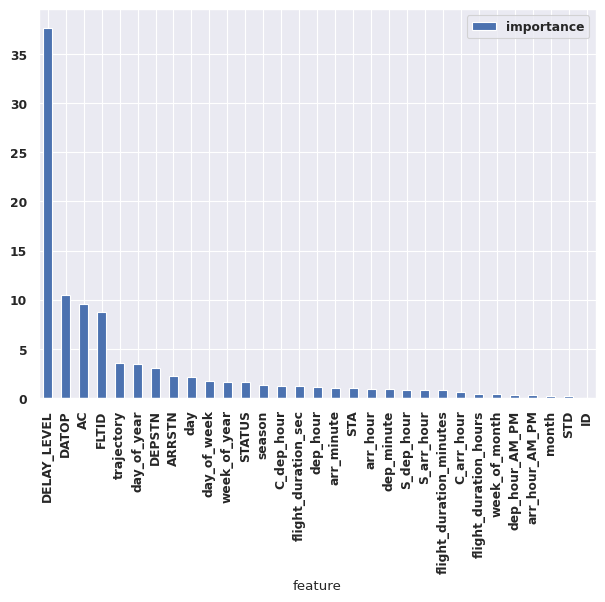

In [ ]:
importances.plot.bar()


In [ ]:
model2=grid.best_estimator_
model2.fit(X, y,cat_features=categ_feat_idx,eval_set=(X_test, y_test))

0:	learn: 115.1117675	test: 116.0692985	best: 116.0692985 (0)	total: 359ms	remaining: 4m 10s
1:	learn: 113.2892894	test: 114.2297788	best: 114.2297788 (1)	total: 479ms	remaining: 2m 47s
2:	learn: 111.5925823	test: 112.5207850	best: 112.5207850 (2)	total: 823ms	remaining: 3m 11s
3:	learn: 110.0301954	test: 110.9378438	best: 110.9378438 (3)	total: 1s	remaining: 2m 55s
4:	learn: 108.5374501	test: 109.4144377	best: 109.4144377 (4)	total: 1.32s	remaining: 3m 4s
5:	learn: 107.1982048	test: 108.0565367	best: 108.0565367 (5)	total: 1.63s	remaining: 3m 8s
6:	learn: 105.9679302	test: 106.7877853	best: 106.7877853 (6)	total: 1.89s	remaining: 3m 7s
7:	learn: 104.8105810	test: 105.6206134	best: 105.6206134 (7)	total: 2.19s	remaining: 3m 9s
8:	learn: 103.7466230	test: 104.5326081	best: 104.5326081 (8)	total: 2.48s	remaining: 3m 10s
9:	learn: 102.7893304	test: 103.5517163	best: 103.5517163 (9)	total: 2.76s	remaining: 3m 10s
10:	learn: 101.9155959	test: 102.6678467	best: 102.6678467 (10)	total: 3.09s	

In [ ]:
# I again fit the model but with the whole dataset to get more data into training
model.fit(X, y,cat_features=categ_feat_idx,eval_set=(X_test, y_test))

0:	learn: 113.2055443	test: 114.1281561	best: 114.1281561 (0)	total: 577ms	remaining: 6m 43s
1:	learn: 109.8446399	test: 110.6773291	best: 110.6773291 (1)	total: 1.15s	remaining: 6m 40s
2:	learn: 107.0403159	test: 107.8490748	best: 107.8490748 (2)	total: 1.69s	remaining: 6m 30s
3:	learn: 104.6391767	test: 105.4567458	best: 105.4567458 (3)	total: 2.61s	remaining: 7m 33s
4:	learn: 102.5809365	test: 103.3750301	best: 103.3750301 (4)	total: 3.62s	remaining: 8m 22s
5:	learn: 100.8070418	test: 101.5705799	best: 101.5705799 (5)	total: 4.52s	remaining: 8m 42s
6:	learn: 99.2966510	test: 100.0093349	best: 100.0093349 (6)	total: 5.5s	remaining: 9m 3s
7:	learn: 97.8806397	test: 98.8461610	best: 98.8461610 (7)	total: 6.22s	remaining: 8m 57s
8:	learn: 96.7958187	test: 97.8319679	best: 97.8319679 (8)	total: 6.82s	remaining: 8m 42s
9:	learn: 95.8807805	test: 96.9238244	best: 96.9238244 (9)	total: 7.37s	remaining: 8m 27s
10:	learn: 94.8709720	test: 96.2035713	best: 96.2035713 (10)	total: 7.89s	remainin

In [ ]:
categ_feat_idx

array([ 0,  2,  3,  4,  7,  8, 10])

In [ ]:
X_test.head()

ID       DATOP    FLTID DEPSTN ARRSTN                  STD  \
69632  train_id_10906  2016-08-14  TU 9145    NBE    TUN  2016-08-14 13:20:00   
88753  train_id_42071  2017-06-11  TU 0914    MED    TUN  2017-06-11 00:40:00   
3041   train_id_51582  2017-11-13  TU 0319    LIS    MAD  2017-11-13 16:45:00   
84105  train_id_57243  2017-12-23  TU 0928    TUN    MRS  2017-12-23 15:05:00   
1829   train_id_47013  2017-03-29  TU 0607    MAD    TUN  2017-03-29 17:25:00   

                       STA STATUS         AC  DELAY_LEVEL trajectory  month  \
69632  2016-08-14 13:55:00    ATA  TU 736ION            0    NBE-TUN      8   
88753  2017-06-11 05:20:00    ATA  TU 332IFM            2    MED-TUN      6   
3041   2017-11-13 18:15:00    ATA  TU 320IMV            0    LIS-MAD     11   
84105  2017-12-23 16:40:00    ATA  TU 31BIMO            1    TUN-MRS     12   
1829   2017-03-29 19:30:00    ATA  TU 32AIMF            1    MAD-TUN      3   

       day  day_of_week  week_of_year  week_of_month  season  dep_hour  \
69632   14            6            32              1       2        13   
88753   11            6            23              1       2         0   
3041    13            0            46              1       3        16   
84105   23            5            51              3       0        15   
1829    29            2            13              4       1        17   

       arr_hour  dep_minute  arr_minute  flight_duration_sec  \
69632        13          20          55                 2100   
88753         5          40          20                16800   
3041         18          45          15                 5400   
84105        16           5          40                 5700   
1829         19          25          30                 7500   

       flight_duration_hours  flight_duration_minutes  dep_hour_AM_PM  \
69632                      0                       35               1   
88753                      5                      280               0   
3041                       2                       90               1   
84105                      1                       95               1   
1829                       2                      125               1   

       arr_hour_AM_PM  S_dep_hour  C_dep_hour  S_arr_hour    C_arr_hour  \
69632               1   -0.258819   -0.965926   -0.258819 -9.659258e-01   
88753               0    0.000000    1.000000    0.965926  2.588190e-01   
3041                1   -0.866025   -0.500000   -1.000000 -1.836970e-16   
84105               1   -0.707107   -0.707107   -0.866025 -5.000000e-01   
1829                1   -0.965926   -0.258819   -0.965926  2.588190e-01   

       day_of_year  
69632        227.0  
88753        162.0  
3041         317.0  
84105        357.0  
1829          88.0

In [ ]:
test.head()

DATOP    FLTID DEPSTN ARRSTN                 STD                 STA  \
0 2016-05-04  TU 0700    DJE    TUN 2016-05-04 06:40:00 2016-05-04 07:30:00   
1 2016-05-05  TU 0395    TUN    BKO 2016-05-05 15:20:00 2016-05-05 20:05:00   
2 2016-05-06  TU 0745    FRA    TUN 2016-05-06 10:00:00 2016-05-06 12:25:00   
3 2016-05-11  TU 0848    BEY    TUN 2016-05-11 09:40:00 2016-05-11 13:10:00   
4 2016-05-11  TU 0635    ORY    MIR 2016-05-11 09:50:00 2016-05-11 12:35:00   

  STATUS         AC trajectory  month  day  day_of_week  year  week_of_year  \
0    ATA  TU 32AIMF    DJE-TUN      5    4            2  2016            18   
1    ATA  TU 320IMW    TUN-BKO      5    5            3  2016            18   
2    ATA  TU 32AIMC    FRA-TUN      5    6            4  2016            18   
3    ATA  TU 31BIMO    BEY-TUN      5   11            2  2016            19   
4    ATA  TU 736IOQ    ORY-MIR      5   11            2  2016            19   

   week_of_month  season  dep_hour  arr_hour  dep_minute  arr_minute  \
0              0       1         6         7          40          30   
1              0       1        15        20          20           5   
2              0       1        10        12           0          25   
3              1       1         9        13          40          10   
4              1       1         9        12          50          35   

   flight_duration_sec  flight_duration_hours  flight_duration_minutes  \
0                 3000                      1                       50   
1                17100                      5                      285   
2                 8700                      2                      145   
3                12600                      4                      210   
4                 9900                      3                      165   

   dep_hour_AM_PM  arr_hour_AM_PM  S_dep_hour    C_dep_hour    S_arr_hour  \
0               0               0    1.000000  6.123234e-17  9.659258e-01   
1               1               1   -0.707107 -7.071068e-01 -8.660254e-01   
2               0               1    0.500000 -8.660254e-01  1.224647e-16   
3               0               1    0.707107 -7.071068e-01 -2.588190e-01   
4               0               1    0.707107 -7.071068e-01  1.224647e-16   

   C_arr_hour  day_of_year  
0   -0.258819        125.0  
1    0.500000        126.0  
2   -1.000000        127.0  
3   -0.965926        132.0  
4   -1.000000        132.0

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9333 entries, 0 to 9332
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   DATOP                    9333 non-null   datetime64[ns]
 1   FLTID                    9333 non-null   object        
 2   DEPSTN                   9333 non-null   object        
 3   ARRSTN                   9333 non-null   object        
 4   STD                      9333 non-null   datetime64[ns]
 5   STA                      9333 non-null   datetime64[ns]
 6   STATUS                   9333 non-null   object        
 7   AC                       9333 non-null   object        
 8   trajectory               9333 non-null   object        
 9   month                    9333 non-null   int32         
 10  day                      9333 non-null   int32         
 11  day_of_week              9333 non-null   int32         
 12  year                     9333 non-

In [ ]:
test['DATOP'] = X['DATOP'].astype(str)
test['STA'] = X['STA'].astype(str)
test['STD'] = X['STD'].astype(str)

In [ ]:
test['FLTID'].nunique()

700

In [ ]:
y_pred = model2.predict(test)

CatBoostError: /src/catboost/catboost/libs/data/model_dataset_compatibility.cpp:81: At position 9 should be feature with name DELAY_LEVEL (found month).

In [ ]:
y_pred = model.predict(test)

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=1]="TU 0700": Cannot convert 'b'TU 0700'' to float

In [ ]:
any(y_pred<0)

NameError: name 'y_pred' is not defined

In [ ]:
y_pred[y_pred < 0] =0

In [ ]:
submission= pd.DataFrame({'ID':df_test["ID"],'target':y_pred})
submission.to_csv("submission.csv",index=False)

<h3> Linear Regression </h3>

In [ ]:
# one_hot = pd.get_dummies(df['STATUS'])
# df = df.drop('STATUS',axis = 1)
# df = df.join(one_hot)

In [ ]:
# one_hot = pd.get_dummies(df['DEPSTN'],prefix='depart_')
# df = df.drop('DEPSTN',axis = 1)
# df = df.join(one_hot)

In [ ]:
# one_hot = pd.get_dummies(df['ARRSTN'], prefix='arrival_')
# df = df.drop('ARRSTN',axis = 1)
# df = df.join(one_hot)

In [ ]:
# one_hot = pd.get_dummies(df['AC'], prefix='ac_')
# df = df.drop('AC',axis = 1)
# df = df.join(one_hot)

In [ ]:
# le = LabelEncoder()
# enc = OneHotEncoder(sparse=False)
# df['DEPSTN'] = le.fit_transform(df['DEPSTN'])
# df['ARRSTN'] = le.fit_transform(df['ARRSTN'])
# df['STATUS'] = le.fit_transform(df['STATUS'])
# df['AC'] = le.fit_transform(df['AC'])

In [ ]:
# df['DATOP_ts'] = df.DATOP.values.astype(np.int64) // 10 ** 9
# df['STD_ts'] = df.STD.values.astype(np.int64) // 10 ** 9
# df['STA_ts'] = df.STA.values.astype(np.int64) // 10 ** 9
# del df['DATOP']
# del df['STA']
# del df['STD']

In [ ]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

ValueError: could not convert string to float: 'train_id_11434'

In [ ]:
results = model.predict(X_test)
score1 = metrics.mean_squared_error(y_test,results)
score2 = metrics.r2_score(y_test,results )
print('MSE: ',score1, '  R2 Score: ', score2)
# MSE:  5954526.582315134   R2 Score:  -461.04557347688393
# when deleting year and ac_frequency MSE:  13643.94079805509   R2 Score:  0.058992522154372895
# WITH label encoding MSE:  12795.027061727462   R2 Score:  0.036762754570380474
# MSE:  12059.485969460224   R2 Score:  0.0421820337368739 labelenc with delet of year and ac_freq

MSE:  12059.485969460224   R2 Score:  0.0421820337368739


In [ ]:
#memory error
for i in range(5,10):
    poly = PolynomialFeatures(degree = i)
    regr = linear_model.LinearRegression()
    X_ = poly.fit_transform(X_train)
    regr.fit(X_, y_train)
    X_ = poly.fit_transform(X_test)
    results = regr.predict(X_)
    score1 = metrics.mean_squared_error(y_test,results )
    score2 = metrics.r2_score(y_test,results )
    print('Model with Polynominal Degree', i, 'MSE: ',score1, '  R2 Score: ', score2)
# 5 : Model with Polynominal Degree 5 MSE:  11915.27537981318   R2 Score:  0.053635879617132454


Model with Polynominal Degree 1 MSE:  12059.485969460296   R2 Score:  0.04218203373686813
Model with Polynominal Degree 2 MSE:  12025.860911835494   R2 Score:  0.044852685238203294
Model with Polynominal Degree 3 MSE:  12667.95185097613   R2 Score:  -0.006145030505330329
Model with Polynominal Degree 4 MSE:  12009.528564292783   R2 Score:  0.046149872858577634
Model with Polynominal Degree 5 MSE:  11915.27537981318   R2 Score:  0.053635879617132454


MemoryError: 